In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
ensembl_to_entrez_path = 'data/ensembl_to_entrez.csv'
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

raw_rna_path = 'data/clean/rna/all_samples_counts.csv'
raw_protein_path = 'data/clean/protein/gene_levels_by_entrez.csv'

rna_tmm_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/tmm_for_subsets.csv'

protein_tmm_normalized_counts_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/tmm_for_subsets.csv'
protein_tmm_normalized_counts_gene_level_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/gene_level_tmm_for_subsets.csv'

rna_rle_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/rle_for_subsets.csv'
protein_rle_normalized_counts_gene_level_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/gene_level_rle_for_subsets.csv'

## Preprocessing, overlap analysis, gene-protein matching

For the majority of analyses I will use TMM normalized data (pre-filtered as for limma), mapped on the gene level:

In [4]:
rna_tmm_counts = read_csv(rna_tmm_normalized_counts_path, index_col=0)
protein_tmm_counts = read_csv(protein_tmm_normalized_counts_path, index_col=0)
protein_tmm_counts_gene_level = read_csv(protein_tmm_normalized_counts_gene_level_path, index_col=0)

In [5]:
rna_rle_counts = read_csv(rna_rle_normalized_counts_path, index_col=0)
protein_rle_counts_gene_level = read_csv(protein_rle_normalized_counts_gene_level_path, index_col=0)

While the raw RNASeq/SOMAScan data are hardly comparable, these are also useful to highlight possible discrepancies arising from technical issues:

In [6]:
raw_rna = read_csv(raw_rna_path, index_col=0)
raw_protein = read_csv(raw_protein_path, index_col=0)

In [7]:
raw_rna.head(2)

,001.TMD,006.CM,012.BM,016.CM,017.TMD,...,158.TMD,167.TMR,175.TMD,233.CM,261.CM
ENSG00000000003,1.0,3.0,2.0,16.0,25.0,...,0.0,0.0,0.0,0.0,25.0
ENSG00000000005,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5.0


In [8]:
raw_protein.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
10273,174.1,521.1,57.0,158.1,62.1,...,12.6,11.4,12.2,15.8,22.2
1051,53.3,283.6,36.1,126.6,33.7,...,10.4,9.7,9.6,11.0,15.1


### 1. The patients overlap is limited and only present for CM, TM and Viral groups

In [9]:
from helpers.venn import venn2

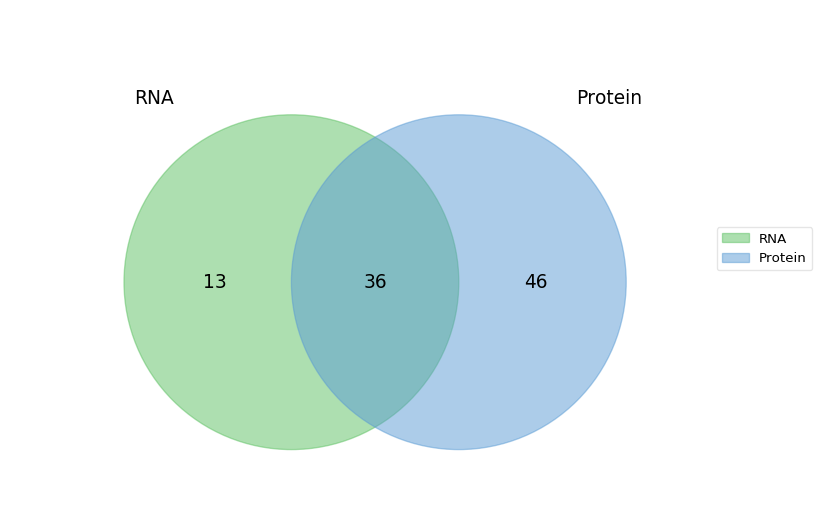

In [10]:
venn2(dict(RNA=rna_tmm_counts.columns, Protein=protein_tmm_counts.columns));

In [11]:
from numpy import nan
from math import log

In [12]:
all_patients = list(rna_tmm_counts.columns | protein_tmm_counts.columns)

assert all(raw_rna > 0) and all(raw_protein > 0)

patients_data = DataFrame(
    data=[{
            'Protein': log(sum(raw_protein[patient])) if patient in raw_protein else nan, 
            'RNA': log(sum(raw_rna[patient])) if patient in raw_rna else nan,
        }
        for patient in all_patients
    ],
    index=all_patients
).T

In [13]:
clinical = read_csv(clinical_path, index_col=0).loc[all_patients]
from plots.annotations import generate_patient_annotations
patient_annotations = generate_patient_annotations(clinical)

In [14]:
patient_annotations['Is RNA outlier'] = [
    patient in raw_rna and patient not in rna_tmm_counts.columns
    for patient in all_patients
]
assert any(patient_annotations['Is RNA outlier'])
patient_annotations.head(2)

,Meningitis,Tuberculosis status,HIV status,Is RNA outlier
PatientID,,,,
001.TMD,Tuberculosis,Definite,Positive,False
006.CM,Cryptococcal,-,Positive,False


In [15]:
patients_data

,001.TMD,006.CM,007.TMD,011.TMR,012.BM,...,247.CM,248.TMD,255.VM,256.CM,261.CM
Protein,16.692534,16.829547,17.15418,NaN,NaN,...,16.315459,17.097623,16.137170,16.604112,NaN
RNA,12.595934,14.060782,NaN,14.260128,15.175231,...,NaN,NaN,14.778364,15.188198,15.01611


In [16]:
joined = patient_annotations.join(patients_data.T)
joined['no_protein'] = joined['Protein'].isnull()
joined['no_rna'] = joined['RNA'].isnull()
ordered = joined.sort_values(['Meningitis', 'Tuberculosis status', 'no_protein', 'no_rna', 'Protein', 'RNA'])

In [17]:
patients_data_ordered = patients_data[ordered.index]
patient_annotations_ordered = patient_annotations.T[ordered.index].T

In [18]:
patient_annotations_ordered['Is RNA outlier'] = patient_annotations_ordered['Is RNA outlier'].astype(str)

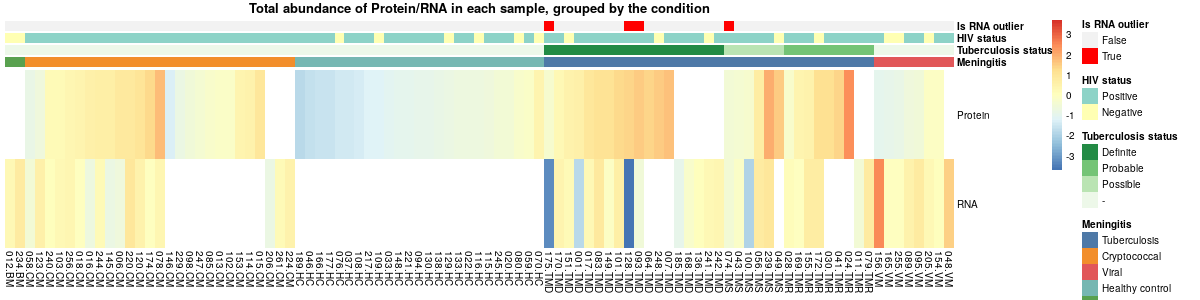

In [19]:
%%R -i patients_data_ordered -i patient_annotations_ordered -w 1200 -h 300
import::here(space_to_dot, dot_to_space, remove_leading_X, .from='helpers/utilities.R')
        
names(patient_annotations_ordered) = dot_to_space(names(patient_annotations_ordered))
colnames(patients_data_ordered) <- remove_leading_X(colnames(patients_data_ordered))

patient_colors$`Is RNA outlier` = c(False='grey95', True='red')

pheatmap::pheatmap(
    patients_data_ordered,
    show_colnames=T, show_rownames=T,
    annotation_col=patient_annotations_ordered,
    annotation_colors=patient_colors,
    cluster_rows=F, cluster_cols=F,
    scale='row',
    border_color='black', na_col='grey100',
    main='Total abundance of Protein/RNA in each sample, grouped by the condition'
)

## 2. Matching genes and proteins

Identifiers mapping:
 - there are multiple transcripts for the same gene (which may be due to different genomic loci or isoforms)
 - the simplest gene level analysis can use Entrez Gene IDs

### Using Entrez Gene ID

Gene-level protein counts are already mapped to Entrez Gene ID (here through UniProt, though aptamers metadata also have Entrez mappings):

In [20]:
protein_tmm_counts_gene_level.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
10273,2.584083,2.985980,1.715789,2.137092,1.956666,...,1.032951,1.322774,1.144986,1.335091,1.109771
1051,0.931204,2.123822,1.082654,1.824871,1.106570,...,0.771316,1.100119,0.817206,0.838019,0.585619


Let's get Entrez Ids for RNA-seq results:

In [21]:
ensembl_to_entrez = read_csv(ensembl_to_entrez_path, index_col=0)
ensembl_to_entrez.head(2)

,NCBI Gene ID
Ensembl gene ID,
ENSG00000121410,1
ENSG00000268895,503538


In [22]:
rna_tmm_counts_entrez = copy(rna_tmm_counts)
rna_tmm_counts_entrez.index = rna_tmm_counts.index.map(ensembl_to_entrez['NCBI Gene ID'])
rna_tmm_counts_entrez.head(2)

,001.TMD,006.CM,012.BM,016.CM,017.TMD,...,174.CM,011.TMR,043.TMS,078.CM,261.CM
7105.0,1.687826,0.750583,0.074813,3.174514,3.290051,...,0.502692,3.201567,3.032622,-1.189430,2.793684
8813.0,-1.189430,2.436818,4.064306,-1.189430,4.792856,...,2.600307,1.211544,-1.189430,5.483702,3.690400


Unfortunately almost 30% genes have no mapping:

In [23]:
sum(rna_tmm_counts_entrez.index.isnull()) / len(rna_tmm_counts_entrez)

0.29036929761042723

NB: this likely affects our MsigDB-based pathways analyses

In [24]:
from helpers.venn import venn2

Despite that we get over 90% of overlap:

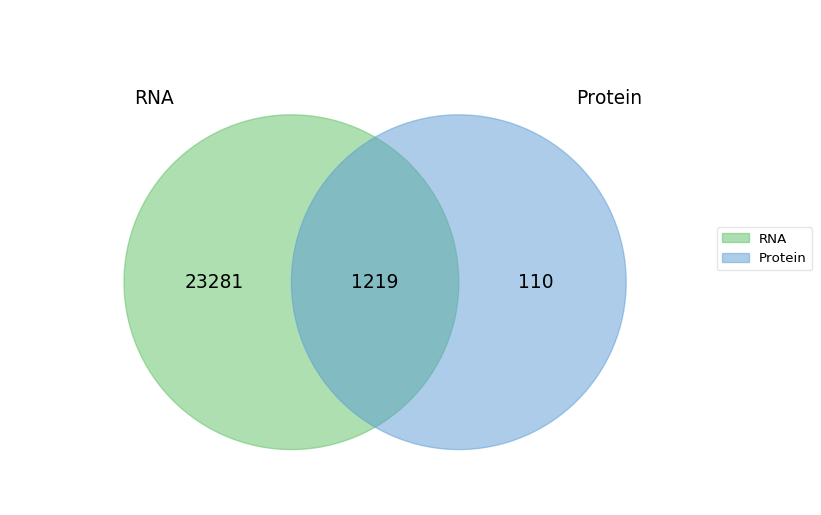

In [25]:
venn2(dict(RNA=rna_tmm_counts_entrez.index, Protein=protein_tmm_counts_gene_level.index));

### Using gene symbols:

In [26]:
protein_tmm_counts.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
CHIP,2.554523,2.978964,1.698778,2.111255,1.934072,...,1.051758,1.301672,1.172738,1.378325,1.105333
CEBPB,0.902148,2.116709,1.065659,1.799091,1.084118,...,0.789761,1.079053,0.844422,0.880240,0.580928


In [27]:
from helpers.ensembl import Ensembl

ensembl = Ensembl(95)

In [28]:
ensembl_to_gene_name = ensembl.merge_gene_data(rna_tmm_counts)[['gene_name']]
ensembl_to_gene_name.head(2)

,gene_name
ENSG00000000003,TSPAN6
ENSG00000000419,DPM1


All identifiers in the RNA-Seq matrix got mapped:

In [29]:
assert set() == (set(ensembl_to_gene_name.index) - set(rna_tmm_counts.index))

And none of the mapped values is null:

In [30]:
assert not any(ensembl_to_gene_name['gene_name'].isnull())

In [31]:
rna_tmm_counts_names = copy(rna_tmm_counts)
rna_tmm_counts_names.index = rna_tmm_counts_names.index.map(lambda x: ensembl_to_gene_name['gene_name'].get(x, x))

#### Naive approach: using protein names

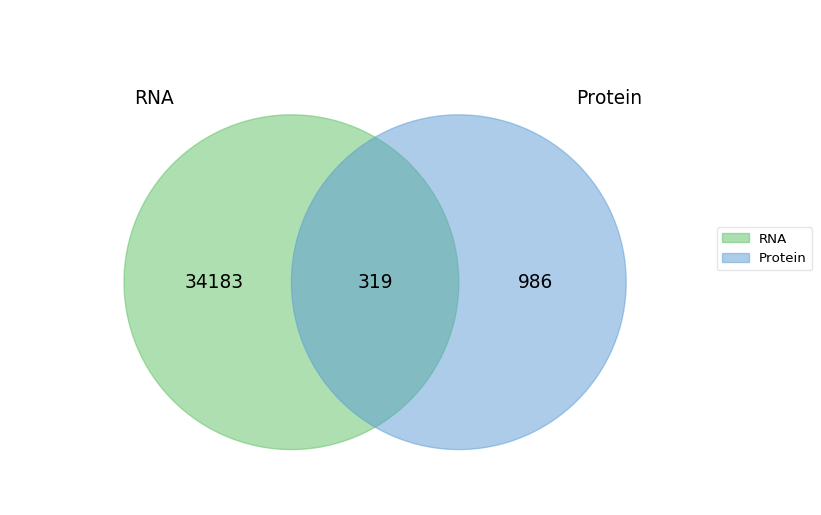

In [32]:
venn2(dict(RNA=rna_tmm_counts_names.index, Protein=protein_tmm_counts.index));

This is because on one side there are Ensembl provided HUGO-based names **gene** and on the other there are **protein** names, which do not have to be the same.

#### A better way: using entrez gene symbols mapping

In [33]:
id_to_symbol_df = read_table('data/hgnc/entrez_ids_to_gene_symbol.tsv', index_col=3)
id_to_symbol = id_to_symbol_df[id_to_symbol_df.Status == 'Approved']['Approved symbol'].to_dict()

In [34]:
gene_symbols = Series(protein_tmm_counts_gene_level.index).apply(lambda x: id_to_symbol.get(x, nan))
sum(gene_symbols.isnull()) / len(gene_symbols)

0.004514672686230248

Finally, keep the old identifier rather than setting nan if no mapping found:

In [35]:
gene_symbols = Series(protein_tmm_counts_gene_level.index).apply(lambda x: id_to_symbol.get(x, x))

In [36]:
protein_tmm_counts_names = protein_tmm_counts_gene_level.loc[list(~gene_symbols.isnull())]
protein_tmm_counts_names.index = list(gene_symbols[~gene_symbols.isnull()])
protein_tmm_counts_names.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
STUB1,2.584083,2.985980,1.715789,2.137092,1.956666,...,1.032951,1.322774,1.144986,1.335091,1.109771
CEBPB,0.931204,2.123822,1.082654,1.824871,1.106570,...,0.771316,1.100119,0.817206,0.838019,0.585619


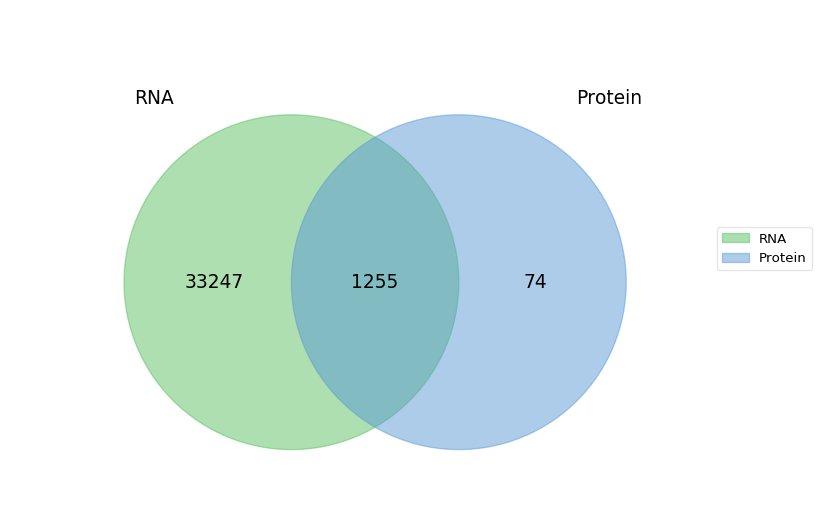

In [37]:
venn2(dict(RNA=rna_tmm_counts_names.index, Protein=protein_tmm_counts_names.index));

So I will use this one (there might be minor isofrorm level generalizations but it's also easier to interpret):

In [38]:
rna = rna_tmm_counts_names
protein = protein_tmm_counts_names

In [39]:
assert not any(rna.index.isnull())
assert not any(protein.index.isnull())

#### Same for RLE

In [40]:
rna_rle_counts_names = copy(rna_rle_counts)
rna_rle_counts_names.index = rna_rle_counts_names.index.map(ensembl_to_gene_name['gene_name'])

protein_rle_counts_names = protein_rle_counts_gene_level.loc[list(~gene_symbols.isnull())]
protein_rle_counts_names.index = list(gene_symbols[~gene_symbols.isnull()])

## Subsetting datasets

In [41]:
patients_with_both = rna.columns & protein.columns
genes_in_both = rna.index & protein.index

In [42]:
rna_shared = rna.loc[genes_in_both, patients_with_both]
protein_shared = protein.loc[genes_in_both, patients_with_both]

## Pre-analyses

### 1. Small but noticeable fraction of measurements is missing RNA-seq counts

In [43]:
values = pd.concat([
    rna_shared.reset_index().melt(id_vars='index').assign(omic='RNA'),
    protein_shared.reset_index().melt(id_vars='index').assign(omic='Protein')
])
values['Meningitis'] = values.variable.map(clinical.Meningitis)
values.head(2)

,index,variable,value,omic,Meningitis
0,FGR,001.TMD,6.941349,RNA,Tuberculosis
1,CFH,001.TMD,-1.189430,RNA,Tuberculosis


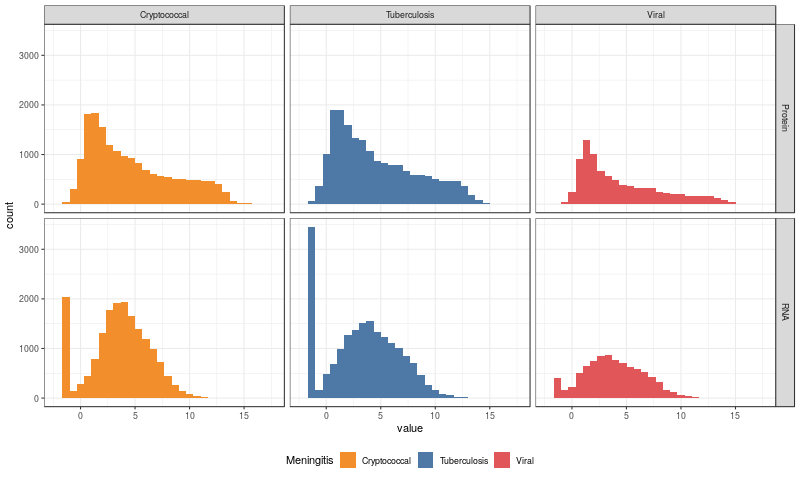

In [44]:
%%R -w 800 -i values
(
    ggplot(values, aes(x=value, fill=Meningitis))
    + facet_grid('omic ~ Meningitis')
    + geom_histogram()
    + scale_fill_manual(values=patient_colors$Meningitis)
    + nice_theme
)

RNA-seq data has clearly many proteins that were not registered for this subset of patients (but not necessarily for all patients - in such case those should have been filtered).
The values appear negative due to the log transformation:

In [45]:
from math import log2

In [46]:
damping_factor = 0.25
log2(0 + damping_factor), log2(1 + damping_factor)

(-2.0, 0.32192809488736235)

And it's about 15% of all RNA values:

In [47]:
values['is_low_count'] = values.value < 0
rna_values = values.query('omic == "RNA"')
len(rna_values.query('is_low_count')) / len(rna_values)

0.15048694112439132

In [48]:
def summarize_low_counts(values):
    return (
        values.groupby(['Meningitis', 'index']).is_low_count.mean().sort_values(ascending=False)
        .to_frame('ratio').reset_index()
    )

In [49]:
rna_low_ratio = summarize_low_counts(rna_values)

There are a few proteins with no (VIP in viral) or almost no counts across all patients in subgroups:

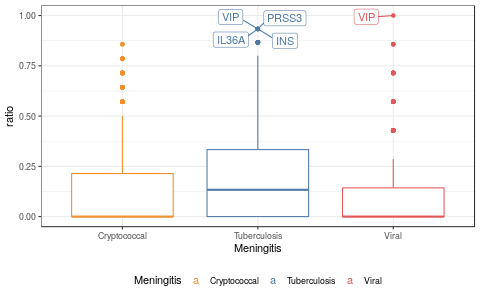

In [50]:
%%R -i rna_low_ratio -h 300
top = rna_low_ratio[rna_low_ratio$ratio >= 0.9,]
(
    ggplot(rna_low_ratio, aes(x=Meningitis, y=ratio, color=Meningitis))
    + geom_boxplot() + color_meningitis + nice_theme
    + ggrepel::geom_label_repel(aes(label=index), data=top, nudge_x=c(-0.2,0.2), direction='y')
)

- VIP - signalling: IL-6, GPCR, Gα.
- IL36α - interleukin 36, inflammatory response, NF-kappa-B and MAPK signaling pathways; thought to be an important factor in counteracting microbial and viral immune evasion [(Jensen LE, 2017)](https://www.ncbi.nlm.nih.gov/pubmed/28811383)
- INS - insulin
- PRSS3 (Trypsin-3) - immune system, neutrophil degranulation, antimicrobial peptides

With even more genes having transcripts completely undetected in the "definite" subgroup of tuberculosis:

In [51]:
tmd_rna_low_ratio = summarize_low_counts(rna_values[rna_values.variable.str.endswith('TMD')])
rna_absent_in_tmd = tmd_rna_low_ratio[tmd_rna_low_ratio.ratio == 1]
rna_absent_in_tmd

,Meningitis,index,ratio
0,Tuberculosis,C8A,1.0
1,Tuberculosis,PRSS3,1.0
2,Tuberculosis,FGB,1.0
3,Tuberculosis,IL20,1.0
4,Tuberculosis,DKKL1,1.0
5,Tuberculosis,IGFBP6,1.0
6,Tuberculosis,HIST1H3D,1.0


- C8A - bacteria killer
- PRSS3 (Trypsin-3) - [as above] immune system, neutrophil degranulation, antimicrobial peptides
- FGB - blood clotting, signaling cascades, platelets, a lot of signaling + VEGFA-VEGFR2
- IL20 - an interleukin 
- DKKL1 - negative regulator of Wnt signaling (dickkopf-like protein)
- IGFBP6 - potential biomarker for TB in HIV+ see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/
- HIST1H3D  - "HIV-1 Tat peptides bind core histones H2A, H2B, H3 and H4, and Tat protein recruits histone acetyltransferases to the HIV-1 LTR promoter leading to acetylation of histones H3 and H4, derepressing chromatin structure and increasing NFkappaB responsiveness"

On IGFBP6:
  > "The remaining two proteins in the HIV+ panel, IGFBP6 and TAGLN2 have unknown roles in infectious diseases. Of note, ligands of IGFBP6 are reduced in sera and pleural fluids of subjects with tuberculous and non-tuberculous pleuritis (Le Bouc et al., 1997)."
 >
 > ![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/bin/gr3.jpg)
 >
 > Fig 3: Differential expression in sera, fold change. ORD = Other respiratory diseases, NI = not infected, LI = latent TB infection, TB = TB infection

From the fig 3 (above) I gather that this is is low against controls (especially in HIV+), and slightly higher against other respiratory diseases (but still not very high).

**TODO** Come to think of it: is the default mean expression filter of DESeq2 wise enough to NOT reject such (completely undetected in one group) cases? Maybe not: fold change in any method would be NaN or zero (but for the damping factor influence, thus more likely +/-∞)! Usually such cases are rare, though such proteins would be perfect biomarkers!

In [52]:
healthy_controls = protein.columns[protein.columns.str.endswith('HC')]
protein_hc = protein.loc[genes_in_both][healthy_controls].reset_index().melt(id_vars='index').assign(omic='Protein', is_low_count=F)

In [53]:
# actually, I could add the patients which are outside of the shared subset here
values_with_hc = pd.concat([values, protein_hc])
values_with_hc['Meningitis'] = values_with_hc.variable.map(clinical.Meningitis)

absent_tmd = values_with_hc.set_index('index').loc[rna_absent_in_tmd['index']].reset_index()

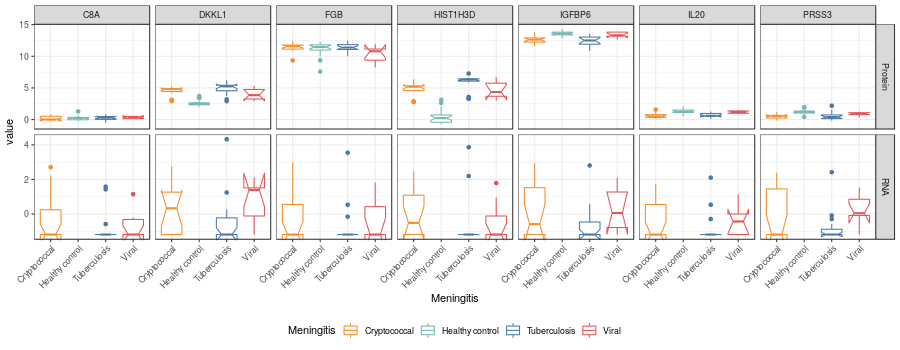

In [54]:
%%R -i absent_tmd -w 900 -h 350
(
    ggplot(absent_tmd, aes(x=Meningitis, y=value, color=Meningitis))
    + geom_boxplot(notch=T) + facet_grid('omic ~ index', scale='free_y')
    + nice_theme + color_meningitis
    + theme(axis.text.x=element_text(angle=45, hjust=1))
)

None of them seem to be differential (for our groups of interest) but there must be a story to be told on IGFBP6 (why is it high in SOMAScan?).

### 2. The RNA and protein profiles are correlated, but not highly

Overall the "naive" correlation (Spearman) between the patient RNA and protein profiles are low:

In [55]:
from scipy.stats import spearmanr

In [56]:
profile_correlations = DataFrame([
    {
        'patient': patient,
        'correlation': spearmanr(protein_shared[patient], rna_shared[patient]).correlation,
        'Meningitis': clinical.loc[patient].Meningitis
    }
    for patient in patients_with_both
]).set_index('patient')

In [57]:
profile_correlations.correlation.mean()

0.11118337072352547

In [58]:
assert profile_correlations.correlation.mean() == profile_correlations.correlation.abs().mean()

And always positvie:

In [59]:
assert (profile_correlations.correlation > 0).all()

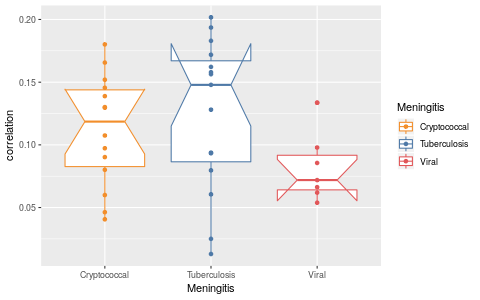

In [60]:
%%R -i profile_correlations -h 300
(
    ggplot(profile_correlations, aes(x=Meningitis, y=correlation, color=Meningitis))
    + geom_boxplot(notch=T) + geom_point()
    + color_meningitis
)

**The correlations for viral meningitis are lower than those for Crypto and TB.**

### 3. Correlations for gene-protein pairs are slightly higher
(with RNASeq-SOMAScan pairs having low RNASeq skipped)

If we were to look at the RNA/protein correlations across the samples, we see the absolute mean correlation to be even higher:

In [61]:
def calc_correlations(rna, protein, method=spearmanr, filter_low_rna_seq=True):
    cor_list = []
    
    for gene in genes_in_both:
        
        r = rna.loc[gene]
        p = protein.loc[gene]
        
        if filter_low_rna_seq:
            # filter out samples (patients) with too few RNA-seq reads for this protein/gene (see above)
            patients_with_enough_rna = r[r > 0].index
            p = p[patients_with_enough_rna]
            r = r[patients_with_enough_rna]
        
        cor = method(r, p)
        
        cor_list.append({
            'gene': gene,
            'rna_abundance': mean(r),
            'protein_abundance': mean(p),
            'mean_abundance': mean(r + p),
            'cross_abundance': mean(r) * mean(p),
            'correlation': cor[0],
            'pvalue': cor[1],
            'n': len(patients_with_enough_rna)
        })
    return DataFrame(cor_list).set_index('gene')

In [62]:
correlations = calc_correlations(rna_shared, protein_shared)
correlations.correlation.abs().mean()

0.17292477460678934

For example the most negatively correlated pairs are:

In [63]:
correlations.sort_values('correlation').head()

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
HIST1H3D,-0.966667,8.044816,6.210554,9,4.369369,0.000022,1.841185
IL17A,-0.779412,1.922482,2.781474,16,1.282721,0.000372,1.498752
PRSS3,-0.745455,0.885991,1.977648,11,0.685869,0.008455,1.291778
IL36A,-0.650000,5.735279,5.287937,9,3.764366,0.058073,1.523571
CA1,-0.644269,7.303764,5.855095,23,4.053057,0.000907,1.802038


$$\text{cross_abundance} = \text{protein_abundance} \times \text{mean_abundance}$$

Looking for biomarkers we are mostly interested in effects:
 - supported consistently by larger number of observations
 - for more abundant proteins and transcripts

Use of P-value can address the first issue and filtering will resolve the second - I will adjust FDR filtering low abundance pairs with genefilter package:

In [64]:
%%R
import::here(filter_by_mean_expression, .from='helpers/independent_hypothesis.R')

add_filtered_fdr = function(correlations, expression_col, alpha=0.1) {
    correlations$FDR = filter_by_mean_expression(
        correlations, alpha, expression_col=expression_col, pvalue_col='pvalue', show_plot=F,
        use_deseq2_method=F
    )
    f = sum(sapply(correlations$FDR, is.na))
    p = sum(sapply(correlations$pvalue, is.na))
    print(paste('Filtered:', f - p))
    correlations
}

In [65]:
from helpers.r import r_function

In [66]:
add_filtered_fdr = partial(r_function, 'add_filtered_fdr')

In [67]:
correlations = add_filtered_fdr(correlations, 'cross_abundance', 0.1)
correlations.sort_values('FDR').head(2)

[1] "Filtered: 408"


,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance,FDR
HIST1H3D,-0.966667,8.044816,6.210554,9,4.369369,0.000022,1.841185,0.018253
FCN1,0.617087,24.109512,10.467347,35,3.422092,0.000079,7.045254,0.033329


### 4. Most significant, highly abundant, highly correlated transcript-protein pairs

Positive correlation can tells us about the type of the cell (if there are cell type specific proteins expressed and measured).

Negative correlation can highlight proteins which are expressed but then exported or used up in another way (binding to complexes - own or foreign, signaling).

These correlations characterize CSF cells in meningitis, but we cannot claim any relation to the healthy individuals yet.

In [68]:
def best_hits(correlations, n=5, sort='FDR'):
    dfs = []
    for direction in ['positively', 'negatively']:
        neg = direction == 'negatively'
        c = correlations[correlations.correlation * (-1 if neg else +1) > 0].sort_values(sort)
        for k in c.head(n).index:
            dfs.append(
                DataFrame(dict(
                    RNA=rna_shared.loc[k], Protein=protein_shared.loc[k]
                )).assign(
                    direction=direction, gene=k, FDR=c.loc[k].FDR, p=c.loc[k].pvalue,
                ).rename_axis('patient').reset_index()
            )
    df = pd.concat(dfs)
    df['Meningitis'] = df.patient.map(clinical['Meningitis'])
    df.gene = pd.Categorical(df.gene, categories=correlations[sort].abs().sort_values().index, ordered=T)
    return df

In [69]:
df = best_hits(correlations, n=5, sort='FDR')

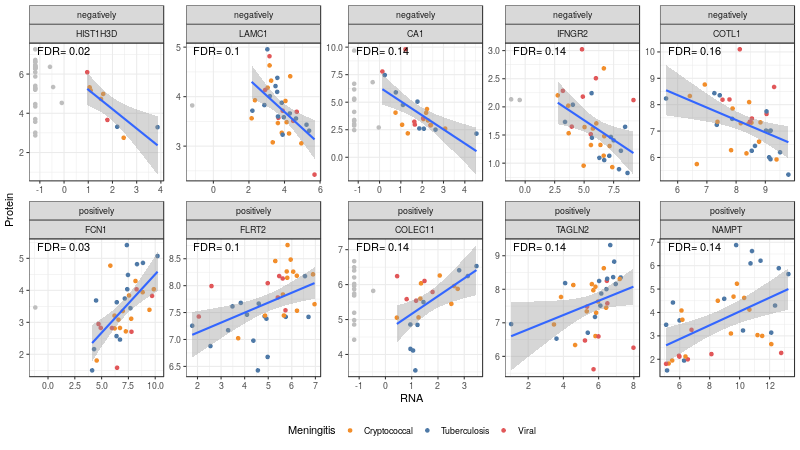

In [70]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('FDR=', round(FDR, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
)

Here are RefSeq based summaries for the above hits:

The most negatively correlated 5:
- HIST1H3D - a histone; may be important in cell proliferation, apoptosis and cell cycle progression (in cancer); RNASeq reads absent in all but two TB patients(!)
- LAMC1 - extracellular matrix glycoprotein; "Upregulated by HIV infection or Tat protein"
- CA1 - zinc metalloenzyme; involved in formation of cerebrospinal fluid (among others); cytosolic, high in erythrocytes; potential oncogene (abnormal cell calcification, apoptosis and migration in breast cancer)
- IFNGR2 - receptor for Interferon gamma (variants are a cause of susceptibility to **mycobacterial** infections!)
- COTL1 - involved in many autoimmune disorders and cancers; related to IL-24/TGF-beta signaling

The most positively correlated 5:
- FCN1 - predominantly expressed in peripheral blood leukocytes; immune system; Neutrophil degranulation; Ebolva virus infection
- FLRT2 - neural development; cell adhesion molecule; possible role in cellular growth and proliferation; tumour suppressor in breast cancer
- COLEC11 - secreted protein; **"important roles in the innate immune system by binding to carbohydrate antigens on microorganisms, facilitating their recognition and removal"**
- TAGLN2 - "thought to be a tumor suppressor", HIV-1 likes this protein: gp120 upregulates it and it needs it to replicate; Platelet activation, signaling and aggregation
- NAMPT - NAPRTase family; involved in many important biological processes, including metabolism, stress response and aging

Further down the list:

In [71]:
integration_path = 'data/integration/'
Path(integration_path).mkdir(exist_ok=True)

In [72]:
export_columns = ['correlation', 'n', 'protein_abundance', 'rna_abundance', 'pvalue', 'FDR']
significant_table = correlations.sort_values('FDR')[export_columns]
significant_table.to_csv(integration_path + 'correlations.csv')

In [73]:
show_table(significant_table.head(20))

,correlation,n,protein_abundance,rna_abundance,pvalue,FDR
HIST1H3D,-0.966667,9,4.369369,1.841185,0.000022,0.018253
FCN1,0.617087,35,3.422092,7.045254,0.000079,0.033329
LAMC1,-0.566106,35,3.768237,3.765978,0.000393,0.099628
FLRT2,0.552896,36,7.678617,4.974119,0.000470,0.099628
NAMPT,0.515830,36,3.667793,8.727463,0.001282,0.140664
COLEC11,0.648786,22,5.489469,1.644922,0.001089,0.140664
CA1,-0.644269,23,4.053057,1.802038,0.000907,0.140664
TAGLN2,0.512999,36,7.595435,5.709453,0.001377,0.140664
IFNGR2,-0.523300,34,1.627658,5.966830,0.001495,0.140664
COTL1,-0.490862,36,7.295692,8.262931,0.002368,0.160997


#### 4.1 The most significant low-expressed pairs

In [74]:
low_expressed = correlations[correlations.FDR.isnull()]
df = best_hits(low_expressed, n=5, sort='pvalue')

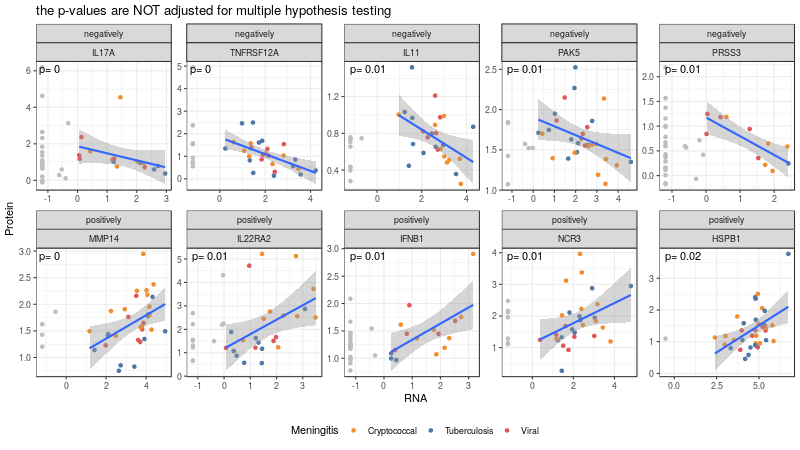

In [75]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('p=', round(p, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
    + ggtitle('the p-values are NOT adjusted for multiple hypothesis testing')
)

- Either interleukins are enriched in SOMAScan design or those have some special role here; correlations:
  - negative: IL17A, IL11
  - positive: IL22RA2 (receptor) [but IL22 is not expressed in 80% of TB patients, 60% of Crypto and 50% of Viral...]
- Interferon Β (IFNB1) has positive correlation while Receptor for Interferon γ (IFNGR2) has negative one
- PRSS3 is not expressed in 93% of the TB patients! (or at least not detected)

In [76]:
rna_low_ratio[rna_low_ratio['index'] == 'IL22']

,Meningitis,index,ratio
24,Tuberculosis,IL22,0.800000
223,Cryptococcal,IL22,0.571429
358,Viral,IL22,0.428571


### 5. Negative correlations are less frequent than positive correlations

(thus should not invalidate the RNASeq analyses, but are an important factor to consider)

In [77]:
# only use pvalue < 0.5, otherwise we are lookking at meaningless noise
# (and I assume that p-values are callibrated up to this level)
not_noise = correlations.query('pvalue < 0.5')

positive_correlations = not_noise.query('correlation > 0')
negative_correlations = not_noise.query('correlation < 0')

In [78]:
len(positive_correlations)

437

In [79]:
len(negative_correlations)

248

#### 5.1 Trends in the pathways space of the positively and negatively correlated pairs differ

Using camera with 1 - p-value gives us an over-representation analysis proxy, but this is actually even worse as it does not use background. Thus, please do not take the FDR/PValue seriously, these are not valid.

In [80]:
from gsea_api.expression_set import ExpressionSet
from gsea_api.molecular_signatures_db import GeneMatrixTransposed
from helpers.gse import collection_to_R

reactome_new_symbol = GeneMatrixTransposed.from_gmt('ReactomePathways.gmt', name='reactome_new_symbol')
collection_to_R(reactome_new_symbol, trim_to=set(genes_in_both))

%R camera = function(x) {limma::cameraPR(x, reactome_new_symbol)}
camera = partial(r_function, 'camera')

In [81]:
# well, actually why would there be any trend for positive correlations?
# this is just how the "normal" cell in the simplest version of the central dogma works,
# so even with proper ORA I would not expect any serious significant signal here
camera(1 - positive_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Non-integrin membrane-ECM interactions,8.0,Up,0.002892,0.969483
Intrinsic Pathway for Apoptosis,5.0,Up,0.013599,0.969483
Signaling by PTK6,9.0,Up,0.016492,0.969483
Signaling by Non-Receptor Tyrosine Kinases,9.0,Up,0.016492,0.969483
Detoxification of Reactive Oxygen Species,2.0,Down,0.019178,0.969483


In [82]:
# kind of as expected ("gut feeling"?), but needs proper ORA framework
camera(1 - negative_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Immune System,101.0,Up,0.001514,0.675596
Cytokine Signaling in Immune system,57.0,Up,0.002538,0.675596
Interleukin-10 signaling,6.0,Up,0.003147,0.675596
Signaling by Interleukins,39.0,Up,0.004533,0.729791
Interleukin-4 and Interleukin-13 signaling,14.0,Up,0.016611,0.989134


I verified using gProfiler and got no significant hits.

In [83]:
# neg = negative_correlations.index

In [84]:
#%%R -i neg -i genes_in_both -o go_result
#go_result <- gprofiler2::gost(neg, custom_bg=genes_in_both, ordered_query=T, significant=T)
#head(go_result)

### 6. A look at the consistently (highly expressed gene-highly abundant protein) pairs (across all groups)

In [85]:
correlations.sort_values('cross_abundance', ascending=False).head(10)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance,FDR
B2M,-0.286229,128.402041,22.684506,36,11.836889,0.090573,10.847617,0.551396
IGHG1,0.044530,112.926118,21.255319,36,10.772678,0.796500,10.482642,0.977732
YWHAZ,-0.180695,112.116291,21.524917,36,12.689689,0.291599,8.835227,0.780203
SELL,-0.108366,107.915142,21.189183,36,12.675513,0.529281,8.513671,0.919029
IGHA1,0.027542,106.507769,20.779532,36,11.589543,0.873315,9.189989,0.979478
ALDOA,-0.025740,102.830890,20.768459,36,12.620596,0.881542,8.147863,0.979478
HNRNPA2B1,0.110682,100.633336,20.071471,36,10.323219,0.520461,9.748252,0.918138
CTSD,-0.224453,98.109711,20.423032,36,12.694528,0.188155,7.728504,0.671664
TNFRSF1B,-0.281081,96.718850,20.212132,36,12.432805,0.096786,7.779326,0.565365
YWHAB,0.037580,95.848418,19.998636,36,12.033510,0.827739,7.965125,0.979191


Top 5:
- B2M - β2-microglubulin: related to MHC, HIV Infection (Host Interactions), IL-12, interferon, TCR singaling
- IGHG1 - immunoglobulin heavy constant gamma; immune system, IL4, IL13
- YWHAZ - mediates signal transduction, lots of pathways, interacts with insulin receptor substrate 1
- SELL - strong association with HIV-1; proposed as biomarker for tuberculosis in HIV negative patients [(Achkar et al, 2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/) (well, maybe this is like checking if they may happen to have latent HIV...)
- IGHA1 - immunoglobulin heavy constant alpha 1; IL17; antibacterial humoral response

Note: I am finding many of the proteins that I check to be associated with to Systemic Lupus. 

### 7. Differential correlations analysis

Are there any pairs positively correlated in one meningitis but negatively in the other?

In [86]:
tm_patients = patients_with_both[patients_with_both.str.contains('TMD|TMR|TMS')]
cm_patients = patients_with_both[patients_with_both.str.contains('CM')]

correlations_tb = calc_correlations(rna_shared[tm_patients], protein_shared[tm_patients])
correlations_cm = calc_correlations(rna_shared[cm_patients], protein_shared[cm_patients])

#### 7.1 Absolute correlations for TB are (on average) higher, and the correlations are more positive for TB

In [87]:
joint_correlations = pd.concat([
    correlations_cm.assign(Meningitis='Cryptococcal'),
    correlations_tb.assign(Meningitis='Tuberculosis')
])
joint_correlations = joint_correlations.assign(abs_correlation=joint_correlations.correlation.abs())

Note: Shapiro-Wilk Normality Test for abs_correlation : p-value = < 0.001
Note: Bartlett's test for homogeneity of variances for factor Meningitis : p-value = < 0.001
Note: Shapiro-Wilk Normality Test for correlation : p-value = 0.001
Note: Bartlett's test for homogeneity of variances for factor Meningitis : p-value = < 0.001


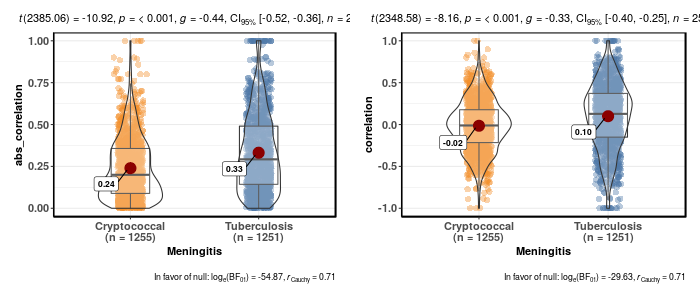

In [88]:
%%R -i joint_correlations -w 700 -h 300
cowplot::plot_grid(
    ggstatsplot::ggbetweenstats(data=joint_correlations, x='Meningitis', y='abs_correlation') + color_meningitis,
    ggstatsplot::ggbetweenstats(data=joint_correlations, x='Meningitis', y='correlation') + color_meningitis
)

And the effect persits after filtering out the non-sigificant hits:

In [89]:
joint_correlations_without_noise = joint_correlations.query('pvalue < 0.1')
joint_correlations_without_noise.groupby('Meningitis').mean()[['correlation', 'abs_correlation']]

,correlation,abs_correlation
Meningitis,,
Cryptococcal,-0.103565,0.611850
Tuberculosis,0.214818,0.635185


- Maybe more proteins measured in the TB are produced "on-site" (in the cells present in the CSF) rather imported with migrating cells which matured outside of the CSF?
- Maybe there are just more proteins measured in the TB, thus it's easier to get a high correlation?

In [90]:
clinical.groupby('Meningitis').Protein.mean().to_frame().T

Meningitis,Bacterial,Cryptococcal,Healthy control,Tuberculosis,Viral
Protein,2.76,1.298889,0.4088,2.894688,0.6925


#### 7.2 In the subsets there are some perfect correlations, but with support from very few patients

Filtering/weighting is thus needed for the subsets as such hits are not very interesting:

In [91]:
correlations_tb.sort_values('pvalue').head(2)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
CST4,1.0,0.069172,0.952579,3,0.079200,0.0,0.873379
DKKL1,-1.0,9.310827,6.736924,3,4.795245,0.0,1.941679


In [92]:
correlations_cm.sort_values('pvalue').head(2)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
CA9,1.0,2.969442,3.470524,4,1.939450,0.0,1.531074
IL17F,-1.0,-0.010303,2.128643,3,-0.004829,0.0,2.133472


I will be weighting the hits by minimal $n$ across the compared groups.

In [93]:
cm_tm = DataFrame(dict(
    cm_correlation=correlations_cm.correlation,
    tb_correlation=correlations_tb.correlation,
    diff=(correlations_cm.correlation - correlations_tb.correlation).abs(),
    mean_abundance=correlations_cm.mean_abundance + correlations_tb.mean_abundance,
    cross_abundance=correlations_cm.cross_abundance * correlations_tb.cross_abundance,
    n=correlations_cm.n + correlations_tb.n,
    cm_n=correlations_cm.n,
    tb_n=correlations_tb.n,
    cross_n=correlations_cm.n * correlations_tb.n
)).dropna().sort_values('diff', ascending=False)

cm_tm.head(2)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,n,cm_n,tb_n,cross_n
gene,,,,,,,,,
CA9,1.0,-1.0,2.0,7.232411,10.476257,6,4,2,8
EFNA2,0.8,-1.0,1.8,20.737359,218.871458,6,4,2,8


Obviously perfect correlation for $n=2$ is not interesting...

#### 6.3 Several gene-protein pairs exhibit opposite correlations in TB and crypto

In [94]:
cm_tm['diff_weighted'] = cm_tm['diff'] * cm_tm[['tb_n', 'cm_n']].min(axis=1)
cm_tm = cm_tm.sort_values('diff_weighted', ascending=False)
show_table(cm_tm.head(15))

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,n,cm_n,tb_n,cross_n,diff_weighted
gene,,,,,,,,,,
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,28,14,14,196,17.723077
KPNB1,-0.459341,0.732143,1.191484,29.429276,2881.055951,29,14,15,210,16.680769
RASA1,-0.380220,0.778571,1.158791,16.333897,184.484078,29,14,15,210,16.223077
STAT1,-0.367033,0.757143,1.124176,28.416894,1734.926398,29,14,15,210,15.738462
TNFRSF8,0.424176,-0.661538,1.085714,13.856433,140.417451,28,14,14,196,15.200000
STAT3,-0.261538,0.789286,1.050824,30.172763,3175.456803,29,14,15,210,14.711538
MICA,0.417582,-0.696429,1.114011,7.746135,-1.537617,28,13,15,195,14.482143
BIRC3,0.292308,-0.721429,1.013736,14.274227,0.304887,29,14,15,210,14.192308
LAG3,-0.336264,0.653571,0.989835,24.183807,1314.945999,29,14,15,210,13.857692


NB: the difference in correlations may be also formulated as minimization of cross-correlation.

What do we miss using the strict $n$ filtering?

In [95]:
from helpers.presentation import compare_sets
non_log = cm_tm.head(15).index
cm_tm['log_diff_weighted'] = cm_tm['diff'] * cm_tm[['tb_n', 'cm_n']].min(axis=1).apply(log2)
log_diff = cm_tm.sort_values('log_diff_weighted', ascending=False).head(15).index
cm_tm.loc[set(log_diff) - set(non_log)]

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,diff_weighted,log_diff_weighted
gene,,,,,,,,,,,
NCR3,-0.318182,0.772727,1.090909,8.818941,22.936674,...,11,11,121,12.000000,3.773925
FUT5,-0.892857,0.800000,1.692857,7.818209,11.798434,...,7,5,35,8.464286,3.930693
BAD,0.709091,-0.503497,1.212587,12.992545,95.769527,...,10,12,120,12.125874,4.028128
EPHA3,-0.450000,0.750000,1.200000,5.012811,0.191381,...,9,9,81,10.800000,3.803910
MATN3,0.633333,-0.666667,1.300000,6.432070,6.235444,...,9,8,72,10.400000,3.900000


In [96]:
top_differences = df= cm_tm.head(10)
df = pd.concat([
    DataFrame(dict(
        RNA=rna_shared.loc[k][rna_shared.loc[k]>0],
        Protein=protein_shared.loc[k][rna_shared.loc[k]>0],
        hcp_q1=protein_hc.set_index('index').loc[k].value.quantile(.25),
        hcp_q2=protein_hc.set_index('index').loc[k].value.quantile(.5),
        hcp_q3=protein_hc.set_index('index').loc[k].value.quantile(.75),
        gene=k,
        diff=top_differences.loc[k]['diff']
    )).rename_axis('patient').reset_index()
    for k in top_differences.index
])
df['Meningitis'] = df.patient.map(clinical['Meningitis'])
df['Tuberculosis'] = df.patient.map(clinical['Tuberculosis'])
df.gene = pd.Categorical(df.gene, categories=top_differences.index, ordered=True)

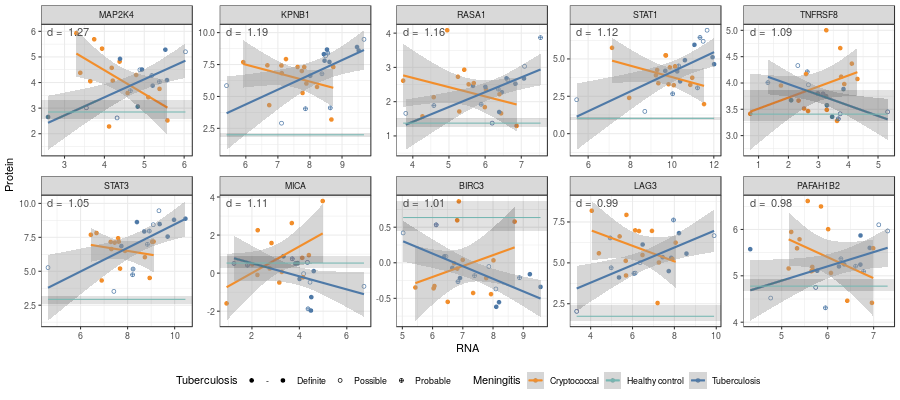

In [97]:
%%R -i df -w 900 -h 400
df = df[df$Meningitis!='Viral',]
(
    ggplot(df, aes(x=RNA, y=Protein, color=Meningitis))
    + facet_wrap('gene', 2, scale='free')
    + geom_point(aes(shape=Tuberculosis))
    + geom_smooth(method='lm')
    + geom_text(aes(label=paste('d = ', round(diff, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15, color='grey30')
    + geom_rect(aes(ymin=hcp_q1, ymax=hcp_q3, xmin=-Inf, xmax=Inf), alpha=0.002, fill='grey', color=NA)
    + geom_line(aes(y=hcp_q2, ymin=hcp_q1, ymax=hcp_q3, xmin=-Inf, xmax=Inf, color='Healthy control'))
    + color_meningitis + nice_theme
    + scale_shape_manual(values=c('-'=19, 'Definite'=19, 'Probable'=10, 'Possible'=1))
)

Top 5 (extracts from NCBI RefSeq gene reports):
- MAP2K4 (a.k.a MKK4; SEK1): Toll Like Receptor cascades, Signaling: MAPK, IL-1, IL-6, Wnt, TNF, TGF-β, FCϵ, ErbB
- KPNB1: HIV-1 replication, apoptosis, Interferon Signaling
- RASA1: stimulates the GTPase activity of RAS p21, Signaling: Aurora A, Aurora B, BCR, FCϵ, EGF/EGFR, EPO, EPHB, Insulin IL-2, IL-3,5, MAPK, NGF, VEGF, RAS and many more; T-Cell Receptor and Co-stimulatory Signaling
- STAT1: "can be activated by various ligands including interferon-alpha, interferon-gamma, EGF, PDGF and IL6 [...] mediates the expression of a variety of genes, which is thought to be important for cell viability in response to different cell stimuli and pathogens";
 - "HIV-1 infection upregulates basal mRNA levels of JUN, IL6, STAT1, CEBPA, RELA, and CEBPG in monocyte derived macrophages"
 - "HIV/**tuberculosis** coinfection upregulates STAT1 expression in pleural fluid mononuclear cells (PFMC) isolated from antiretroviral-naive coinfected patients (relative to patients infected with tuberculosis only)"
- TNFRSF8: TNF-receptor; expressed by activated T and B cells; interactions with HIV-1

The top 6 - STAT3 has a similar behaviour to STAT1 (and both are higher in TB and crypto than in HC!)

After comparing to the healthy controls we could say that KPNB1, STAT1, STAT3, BIRC3 and LAG3 may be worth investigating.

As I have held out some data (samples which are not shared are not included in is shared_protein not in shared_rna), we can now try independently validate if the abundance levels differ between crypto and TB:

TODO

# Simple PLS regression

Toolkit: PLSRegression in sklearn has multiple issues (and it has no maintainer as non of the core developers use it). Thus it may not be the best implementation of the algorithm (plus I looked though it and there are minor modifications to the reference from Wold that I do not fully understand yet). But as a first step it was "good enough":

In [98]:
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

According to the documentation, `PLSRegression` produces results equivalent to:
>- "mixOmics" with function `pls(X, Y, mode = "regression")`
>- "plspm " with function `plsreg2(X, Y)`
>- "pls" with function `oscorespls.fit(X, Y)`

while `PLSCanonical`:
 > implements the 2 blocks canonical PLS of the original Wold algorithm [Tenenhaus 1998] p.204, referred as PLS-C2A in [Wegelin 2000].

Both use NIPALS algorithm (sklearn version 'A'); the differences are in:
 - the deflation_mode (regression/canonical); this changes meaning of P & Q (regression of X vs regression of Y)
 - normalization of y weights (no/yes)
 
Notes: S. Wold et al, 2001 uses norm_y_weights=yes (p. 118, step E)

Known bugs in sklearn PLS implementation:
 - values are are not rescaled back after prediction
 - https://github.com/scikit-learn/scikit-learn/issues/4122

$${\displaystyle X=TP^{\mathrm {T} }+E}$$
$${\displaystyle Y=UQ^{\mathrm {T} }+F}$$

In [99]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RepeatedKFold, LeaveOneOut, ShuffleSplit

1. Assessing performance and choosing number of latent variables with cross-validation
2. Applying to the entire dataset for exploration
3. Analysis of latent factors

As suggested I will focus on the TMD-CM subset:

In [100]:
cm_and_tmd = patients_with_both[patients_with_both.str.contains('TMD|CM')]

In [101]:
rs = rna.loc[genes_in_both, cm_and_tmd]
ps = protein.loc[genes_in_both, cm_and_tmd]

In [102]:
def patient_counts(data):
    return DataFrame({
        k: v.columns.map(clinical.Meningitis).value_counts()
        for k, v in data.items()
    })

In [103]:
patient_counts({'RNA': rs, 'Protein': ps})

,RNA,Protein
Cryptococcal,14,14
Tuberculosis,7,7


However as there are only 7 patients, this may not be enough for a sensible model. For PLS-DA this would mean learning on 4-5 TB patients and testing on two, which will lead to all sorts of problems.

In [104]:
# using full TB data is one way to workaround low number of TMD samples for PLS-DA
cm_and_tm = patients_with_both[patients_with_both.str.contains('TMD|TMS|TMR|CM')]

## A) Integration: regressing genes (PLS: TMD & CM)

(X=RNA, Y=Protein, observations=transcripts/proteins)

hypothesis: there are subgroups of patients for which the RNA-Protein balance is different than for others (as I have demonstrated above, there are hints that different signaling processes may underlay such potential stratification)

While for the PLS-DA I need an exact correspondence of observations (for DA model: patients), for the PLS model which would look at the gene-protein relation I could include all patients (not only those for whom the data are shared):

In [105]:
p = protein.loc[genes_in_both,protein.columns.str.contains('TMD|CM')]
r = rna.loc[genes_in_both,rna.columns.str.contains('TMD|CM')]

In [106]:
patient_counts({'RNA': r, 'Protein': p})

,RNA,Protein
Cryptococcal,17,24
Tuberculosis,12,13


In [107]:
# Note; one could argue that the normalization should happen after split
X_train, X_test, Y_train, Y_test = train_test_split(r, p, random_state=0)

In [108]:
X_train.head(2)

,001.TMD,006.CM,016.CM,017.TMD,018.CM,...,206.CM,185.TMD,174.CM,078.CM,261.CM
DDX19B,-1.18943,1.068422,4.319018,4.067491,3.883897,...,3.728469,2.687380,3.739893,4.676069,4.565402
PRSS1,-1.18943,-1.189430,2.665447,-1.189430,-1.189430,...,2.878618,3.325784,2.200563,-0.675254,2.354802


### Learning process visualization

In [109]:
genes_for_viz = Series(genes_in_both).sample(100)
r.loc[genes_for_viz].to_csv('.r.csv')
p.loc[genes_for_viz].to_csv('.p.csv')

See PLS.ipynb for videos with animation.

### Using sklearn

#### Choosing the number of latent factors

In [110]:
from sklearn.model_selection import GridSearchCV

In [111]:
tuned_parameters = [
    # giving two conditions (TMD and CM) we expect at least two components
    {'n_components': range(1, 20)}
]

Wold et al, 2001 described two cross-validation based procedures to asses the number of PLS components $A$ (3.8):
 - "sequential", which needs to be integrated into the PLS algorithm, and
 - "total", which is a standard re-run of the algorithm
 
and both are expected to give similar results (p. 117).

The objective is the minimal predictive residual sum of squares (PRESS) divided by a measure of dimensionality reduction:

$$\frac{\text{PRESS}}{N - A -1}$$

where $N$ is the total number of observations.

TODO: $R^2$ formulation is also used, though not sure about the use for "total" procedure.

In [112]:
from sklearn import metrics

In [113]:
def weighted_press(estimator, x, y):
    # Note: it looks in the publication like they define N before CV
    # (though I am not sure) but this this should not make a big difference
    N = estimator.x_scores_.shape[0]
    A = estimator.n_components
    return metrics.mean_squared_error(estimator.predict(x), y) / (N - A - 1)

In [114]:
from helpers.pls import custom_scorer, format_grid_results
from functools import partial

cv_scoring = {
    '-PRESS/(N-A-1)': custom_scorer(weighted_press, greater_is_better=False),
    'r2_score': 'r2'
}

cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=0)

press_grid_search = partial(
    GridSearchCV,
    cv=cv,
    scoring=cv_scoring,
    refit='-PRESS/(N-A-1)'
)

In [115]:
reg = press_grid_search(PLSRegression(scale=T), param_grid=tuned_parameters)
reg.fit(X_train, Y_train);
reg.best_params_

{'n_components': 3}

In [116]:
grid_results = format_grid_results(reg)
grid_results.head(2)

,param_n_components,variable,value,scoring,split
0,1.0,split0_test_-PRESS/(N-A-1),-0.022166,-PRESS/(N-A-1),0
1,2.0,split0_test_-PRESS/(N-A-1),-0.021561,-PRESS/(N-A-1),0


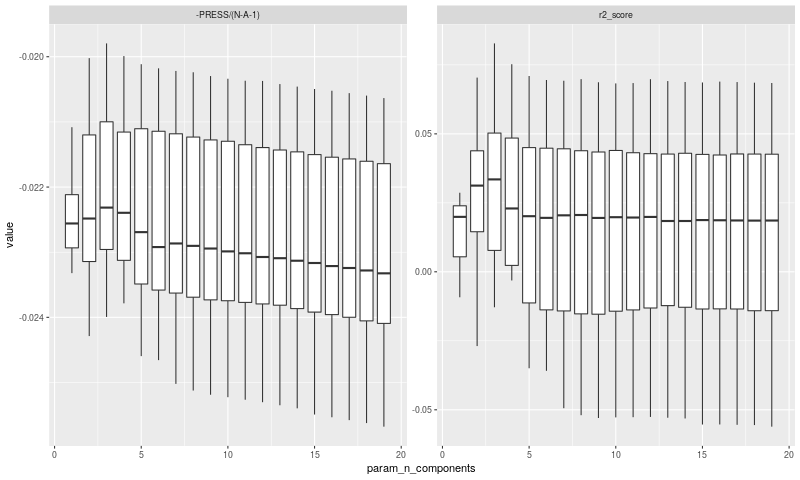

In [117]:
%%R -i grid_results -w 800
grid_search_plot = function(grid) { 
    (
        ggplot(grid, aes(
            y=value,
            group=param_n_components,
            x=param_n_components
        ))
        + facet_wrap('scoring', scale='free_y')
        + geom_boxplot()
    )
}
grid_search_plot(grid_results)

Note: The number of latent factors could be further verified using multiscale bootstrapping. But on observations or on features?

In [118]:
Y_true, Y_pred = Y_test, reg.predict(X_test)
metrics.r2_score(Y_true, Y_pred)

0.03307800639323381

0.03 is not a very good performance.

- I also tried using the RLE normalization, getting very similar results for all models.
- PLSCanonical has always negative R^2 in this scenario

Applying to the full dataset:

In [119]:
# use of my custom Pandas* wrappers allows to easily access
# the resulting matrices in DataFrame form
from helpers.pls import PandasPLSCanonical, PandasPLSRegression

In [120]:
pls = PandasPLSRegression(n_components=3, scale=F)

In [121]:
# even on the full learning data it is not overfitting too much (as this is not so easy with n=3)
r_scores, p_scores = pls.fit_transform(r, p)
pls.score(r, p)

0.07240807187136496

In [122]:
# but let's keep the test separate:
pls.fit(X_train, Y_train)
train_r_scores, train_p_scores = pls.transform(X_train, Y_train)
test_r_scores, test_p_scores = pls.transform(X_test, Y_test)
pls.score(X_test, Y_test)

0.04247477547285323

In [123]:
from helpers.pls import format_test_train_scores

scores = format_test_train_scores(
    train_r_scores, train_p_scores,
    test_r_scores, test_p_scores
)

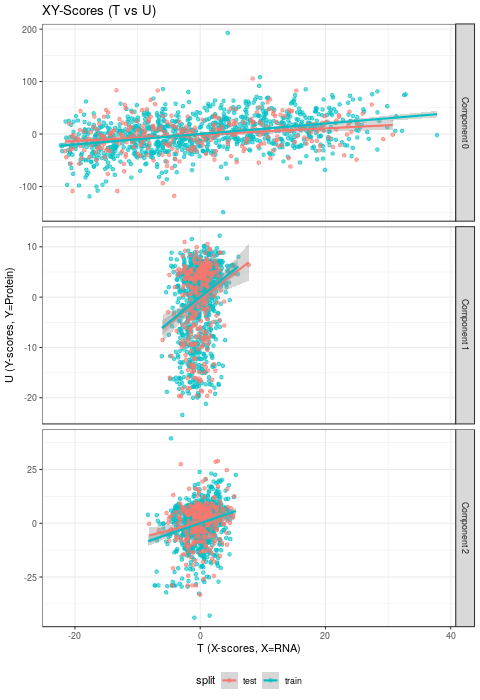

In [124]:
%%R -i scores -h 700

labels = list(
    'T'='T (X-scores, X=RNA)',
    'U'='U (Y-scores, Y=Protein)'
)

plot_xy_scores = function(scores) {
    (
        ggplot(scores, aes(x=T, y=U, color=split))
        + facet_grid('component', labeller=function(i){lapply(i, FUN=function(x) paste('Component', x))}, scale='free')
        + geom_point(alpha=0.6)
        + geom_smooth(method='lm')
        + nice_theme
        + labs(x=labels['T'], y=labels['U'])
        + ggtitle('XY-Scores (T vs U)')
    )
}
plot_xy_scores(scores)

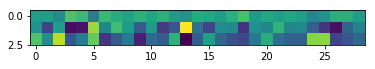

In [125]:
import matplotlib.pyplot as plt
plt.imshow(pls.W.T);

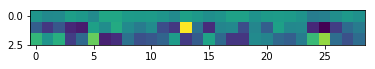

In [126]:
plt.imshow(pls.P.T);

Which patients provide the most value?

In [127]:
w = pls.W

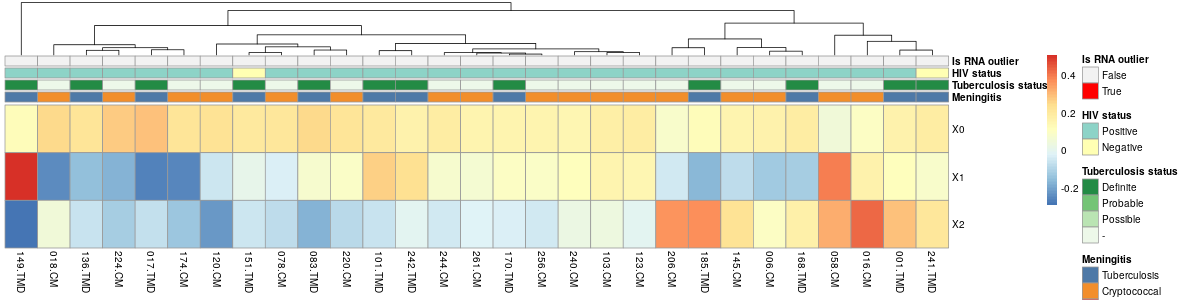

In [128]:
%%R -i w -w 1200 -h 300
weights_heatmap = function(w, annotation=patient_annotations_ordered, ...) {
    w = t(w)
    colnames(w) <- remove_leading_X(colnames(w))
    pheatmap::pheatmap(
        w,
        show_colnames=T, show_rownames=T,
        annotation_col=annotation,
        annotation_colors=patient_colors,
        cluster_rows=F, cluster_cols=T
    )
}

weights_heatmap(w)

In [129]:
w = w.reset_index()

In [130]:
pls.Q.T

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,229.CM,240.CM,244.CM,247.CM,256.CM
0,0.043941,0.046742,0.051739,0.045880,0.050929,...,0.019560,0.036698,0.043128,0.031337,0.029658
1,-0.361502,-0.307136,-0.450657,-0.345924,-0.363321,...,-0.519981,-0.439096,-0.452855,-0.499532,-0.441410
2,-0.218298,-0.206634,-0.218469,-0.233966,-0.251942,...,-0.077552,-0.146341,-0.202034,-0.096906,-0.190624


TODO:
- what is the stability of the latent factors upon bootstrapping?
- what are the latent factors?
- add correlations coefficients above, add plots for other combinations
- loadings plot (!!!!!!)

### Using rOPLS

In [131]:
%R import::here(plot_opls, plot_opls_all, plot_summary, run_and_plot_opls, .from='plots/ropls.R')

In [132]:
%R -i X_train -i Y_train

In [133]:
%R -i r -i p

In [134]:
%R pca = ropls::opls(r);

PCA
1255 samples x 29 variables
standard scaling of predictors
      R2X(cum) pre ort
Total     0.75   1   0


Just one significant RNA component in PCA

In [135]:
%R pca = ropls::opls(p);

PCA
1255 samples x 37 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.944   1   0


Same for protein. TODO what are the criteria used for significance?

In [136]:
%R model = ropls::opls(r, as.matrix(p));

PLS
1255 samples x 29 variables and 37 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.767    0.066  0.0396  3.67   2   0


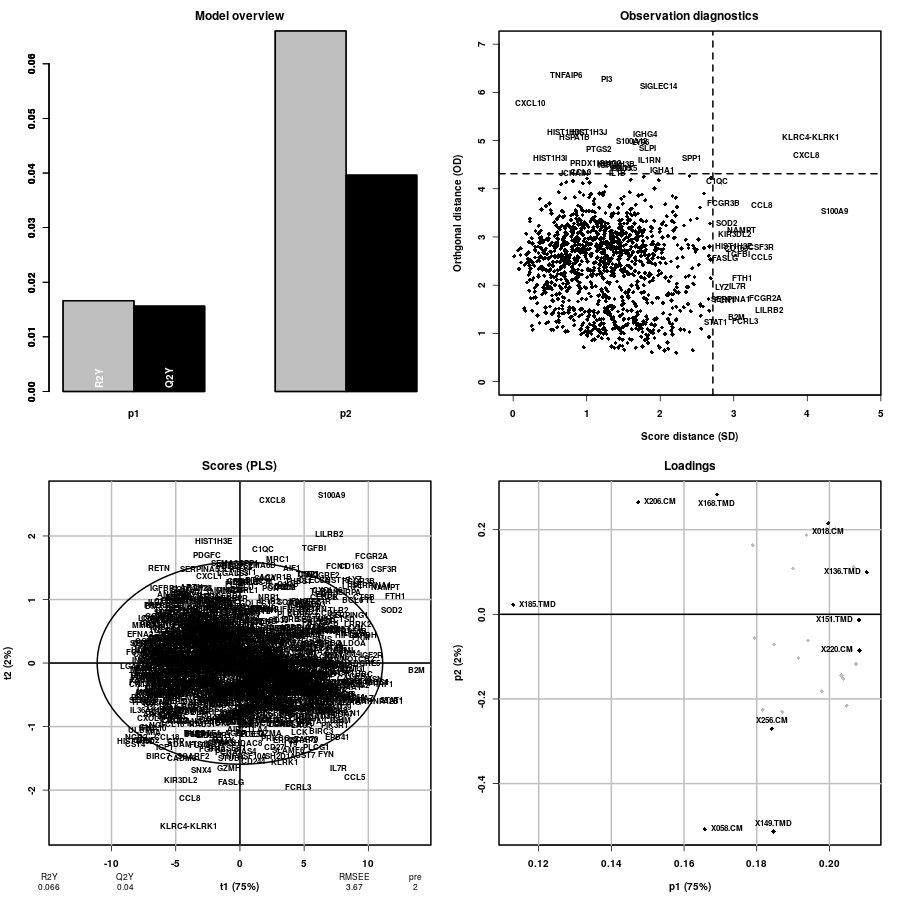

In [137]:
%%R -w 900 -h 900
plot_summary(model)

> Figure 1: PCA summary plot. Top left overview: the scree plot (i.e., inertia barplot) suggests that 3 components may be sufficient to capture most of the inertia; Top right outlier: this graphics shows the distances within and orthogonal to the projection plane (Hubert, Rousseeuw, and Vanden Branden 2005): the name of the samples with a high value for at least one of the distances are indicated; Bottom left x-score: the variance along each axis equals the variance captured by each component: it therefore depends on the total variance of the dataMatrix X and of the percentage of this variance captured by the component (indicated in the labels); it decreases when going from one component to a component with higher indice; Bottom right x-loading: the 3 variables with most extreme values (positive and negative) for each loading are black colored and labeled. (https://bioconductor.org/packages/release/bioc/vignettes/ropls/inst/doc/ropls-vignette.html)

Now, interpretation of this model is not obvious. We cannot claim anything about difference between conditions nor do we have a healthy control here.

The goal was to see whether there are any groups of transcript-protein pairs which behave differently to majority (so being negatively correlated or maybe extremely positively correlated). This model may not be sufficient to answer this question because there are only two components.

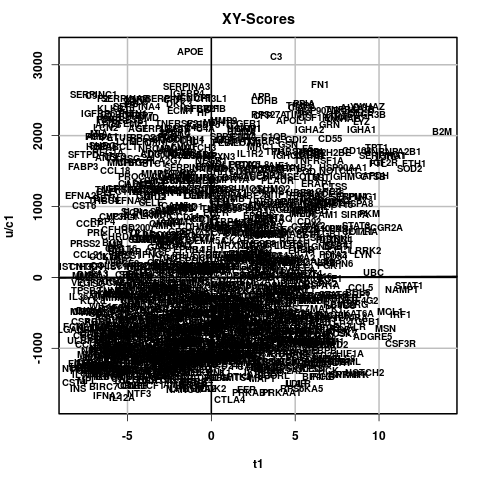

In [138]:
%R plot_opls(model, 'xy-score')

So it reflects the general relation (positive correlation).

Better results may be obtained enforcing more components. Additionally, separating conditions into two models would enable some sort of comparison.

An additional use of this model is in the T scores interpretation; ultimately, this is like PCA on RNASeq but aware of the impact on the protein levels. I think of it as a weighting which makes PCA components potentially more relevant.

As this describes both the groups (TMD and CM), I expect to find HIV related genes here rather than genes related to TB/CM as those would be differential:

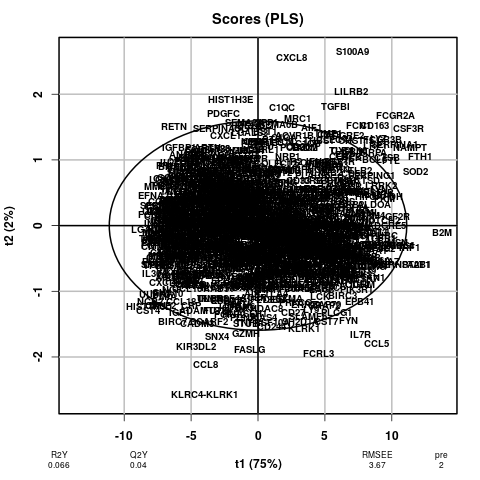

In [139]:
%R plot_opls(model, 'x-score')

A few words on some (arbitrarily) chosen genes which span the X-scores:

T1 top 3:

- KLRK1 "killer cell lectin like receptor K1", "Natural killer (NK) cells are lymphocytes that can mediate lysis of certain tumor cells and virus-infected cells without previous activation. They can also regulate specific humoral and cell-mediated immunity.", "The surface expression of these ligands is important for the recognition of stressed cells by the immune system, and thus this protein and its ligands are therapeutic targets for the treatment of immune diseases and cancers. Read-through transcription exists between this gene and the upstream KLRC4"
- S100A9 - Toll-Like Receptors Cascades, IL-17, Neutrophil degranulation, Antimicrobial peptide, HIV infection decreases levels
- CXCL8 - Interleukin 8; many HIV interactions; many pathways

T2 top 3:
- B2M: β2-microglubulin: related to MHC, HIV Infection (Host Interactions), IL-12, interferon, TCR singaling;
 - **the most highly expressed**, see point 6
- HIST1H3D: - "HIV-1 Tat peptides bind core histones H2A, H2B, H3 and H4, and Tat protein recruits histone acetyltransferases to the HIV-1 LTR promoter leading to acetylation of histones H3 and H4, derepressing chromatin structure and increasing NFkappaB responsiveness":
 - **absent in TMD** (and almost absent in most of TM), see point 1,
 - **the most highly negatively correlated gene-protein pair**, see point 4
- CST4: cystatin S "cysteine proteinase inhibitors found in a variety of human fluids and secretions" "high level of expression in saliva, tears and seminal plasma. The specific role in these fluids is unclear but antibacterial and antiviral activity is present, consistent with a protective function"
 - perfect correlation but very little support, see point 7.2

### AA) Regressing genes with late integration

and more components enforced

In [140]:
p_tmd = protein.loc[genes_in_both,protein.columns.str.contains('TMD')]
p_cm = protein.loc[genes_in_both,protein.columns.str.contains('CM')]
r_tmd = rna.loc[genes_in_both,rna.columns.str.contains('CM')]
r_cm = rna.loc[genes_in_both,rna.columns.str.contains('CM')]

In [141]:
%R -i p_tmd -i p_cm -i r_tmd -i r_cm

Number of components chosen to maximize it but keep positive Q2 (preventing overfiting) the forced increase in number of latent factors comes at expense of overfitted model:

In [142]:
%R model_tmd = ropls::opls(r_tmd, as.matrix(p_tmd), predI=4);

PLS
1255 samples x 17 variables and 13 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.851   0.0644  0.0215  3.64   4   0


In [143]:
%R model_cm = ropls::opls(r_cm, as.matrix(p_cm), predI=4);

PLS
1255 samples x 17 variables and 24 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.851   0.0591  0.0138  3.71   4   0


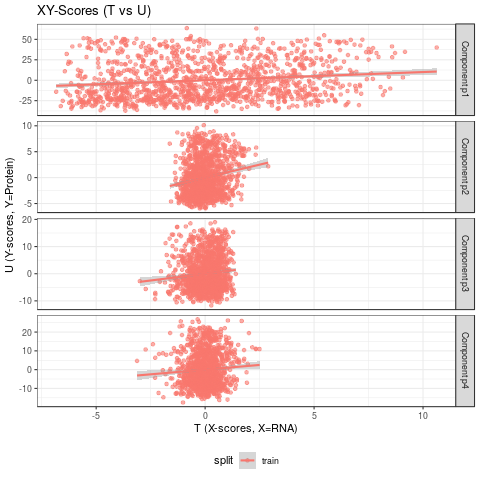

In [144]:
%%R
melt_xy_scores = function(model, split_name='train') {
    t = reshape2::melt(model@scoreMN, value.name='T', varnames=c('gene', 'component'))
    u = reshape2::melt(model@uMN, value.name='U', varnames=c('gene', 'component'))
    tu = merge(t, u, by=c('gene', 'component'))
    tu$split = split_name
    tu
}
scores = melt_xy_scores(model_tmd)
plot_xy_scores(scores)

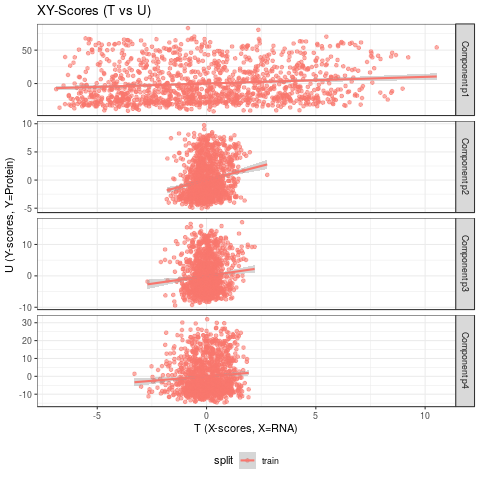

In [145]:
%%R
scores = melt_xy_scores(model_cm)
plot_xy_scores(scores)

In both cases all the components model positive relation. The modeled relations are similar.

The scale difference shows how the most of the protein variation is captured in the first component.

## B) Early integration by profiles (PLS: TMD & CM, observations=patients)

Again, here I could include all transcript/proteins:

In [146]:
ra = rna.loc[:, cm_and_tmd].T
pa = protein.loc[:, cm_and_tmd].T

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(ra, pa, random_state=0)

In [148]:
from warnings import catch_warnings
reg = press_grid_search(PLSRegression(scale=F), param_grid=[
    {
        'n_components': range(
            1,
            # we cannot have more components than observations
            # (and in cros-validation there are fewer observations available)
            min(len(a) for a, b in cv.split(X_train))
        )
    }
])

with catch_warnings(record=T) as w:
    reg.fit(X_train, Y_train);

print(len(w), 'warnings')
reg.best_params_, reg.best_score_

19 warnings


({'n_components': 1}, -0.08993526572996823)

In [149]:
reg.best_estimator_.score(X_train, Y_train)

0.24173142961877056

In [150]:
grid_results = format_grid_results(reg)

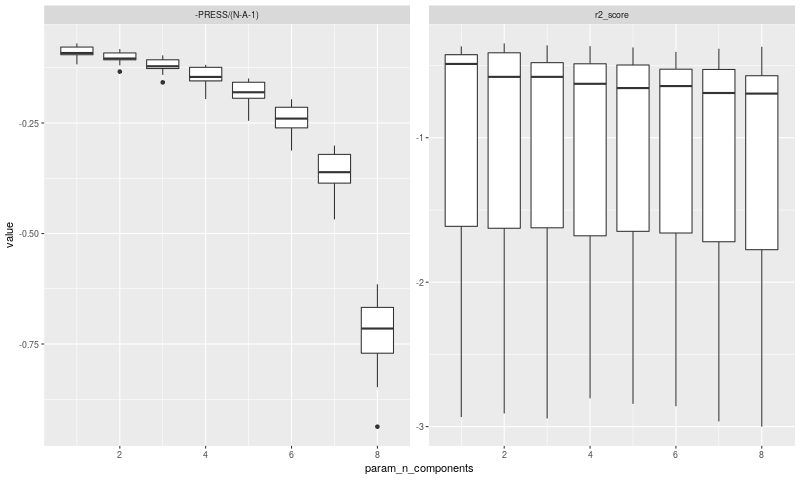

In [151]:
%%R -i grid_results -w 800
grid_search_plot(grid_results)

TODO: should I replace values below 0 (having very little reads in RNASeq, so that after log transformation the value is < 0) with nan?

In [152]:
pls = PandasPLSRegression(n_components=1, scale=F)
pls.fit(X_train, Y_train)
pls.score(X_test, Y_test)

-0.24234142268902775

In [153]:
w = pls.W

In [154]:
%%R -i w -w 1200 -h 300
# well, this is quite useless with just one component
# weights_heatmap(w, annotation=NA)

NULL


But I still could do pathway analysis on 1 component....

### Using mixOmics

In [155]:
%%R -i X_train -i Y_train
p = mixOmics::pls(X_train, Y_train, ncomp=3)
p$explained_variance

$X
    comp 1     comp 2     comp 3 
0.20915864 0.09600080 0.06646587 

$Y
   comp 1    comp 2    comp 3 
0.3057144 0.1784427 0.1253515 



In [156]:
%%R -i X_test
# It is not immediately obvious how to combine layers in Y_predict
Y_predict = predict(p, X_test)

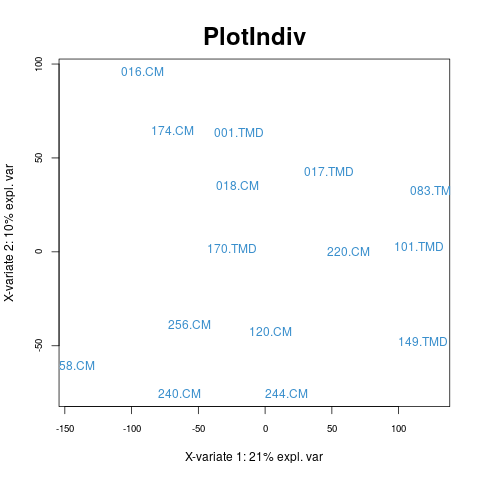

In [157]:
%%R
mixOmics::plotIndiv(p, comp = 1:2, rep.space = "X-variate",style="graphics",ind.names=TRUE)
points(Y_predict$variates[, 1], Y_predict$variates[, 2], pch = 19, cex = 1.2)
text(Y_predict$variates[, 1], Y_predict$variates[, 2], rownames(X_test), pos = 3)

### Using rOPLS

In [158]:
%R pca = ropls::opls(X_train);

PCA
15 samples x 34490 variables
standard scaling of predictors
12 excluded variables (near zero variance)
      R2X(cum) pre ort
Total    0.518   4   0


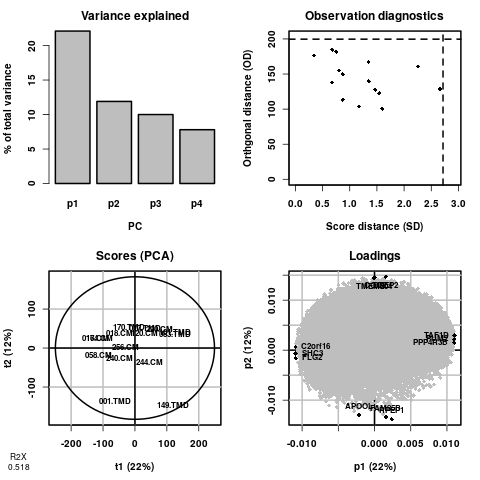

In [159]:
%R plot_summary(pca)

Building model fails with PLS of ropls package as well:

In [160]:
%R ropls::opls(X_train, as.matrix(Y_train))


Error: No model was built because the first predictive component was already not significant;
Select a number of predictive components of 1 if you want the algorithm to compute a model despite this.


In [161]:
%R -i ra -i pa

Even when using full data set (without putting the validation subset aside)

In [162]:
%R ropls::opls(ra, as.matrix(pa))


Error: No model was built because the first predictive component was already not significant;
Select a number of predictive components of 1 if you want the algorithm to compute a model despite this.


Though we can force usage of as many components as we like:

In [163]:
%R model = ropls::opls(ra, as.matrix(pa), predI=2);

PLS
21 samples x 34502 variables and 1329 responses
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
Total    0.259    0.315  0.0564 0.721   2   0


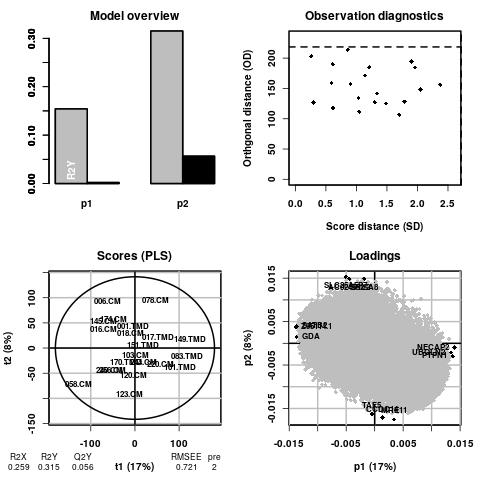

In [164]:
%%R -w 480 -h 480
plot_summary(model)

In [165]:
meningitis = clinical.loc[ra.index].Meningitis

In [166]:
%%R -i meningitis
plot_opls(
    model, typeVc = "x-score", parAsColFcVn=meningitis,
    # does not work in this version yet... need to update bioconductor
    parPaletteVc=as.character(patient_colors[['Meningitis']][unique(meningitis)]
)


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:7:1: unexpected '}'
6: 
7: }
   ^


In [167]:
%%R
# TODO create a better vis with ggplot using:
head(attr(model, 'scoreMN'))

                 p1        p2
001.TMD   -3.555905  44.55539
006.CM   -63.116696  94.33204
016.CM   -70.895253  38.23368
017.TMD   52.636491  22.00898
018.CM    -9.382544  29.87743
058.CM  -127.685171 -71.78473


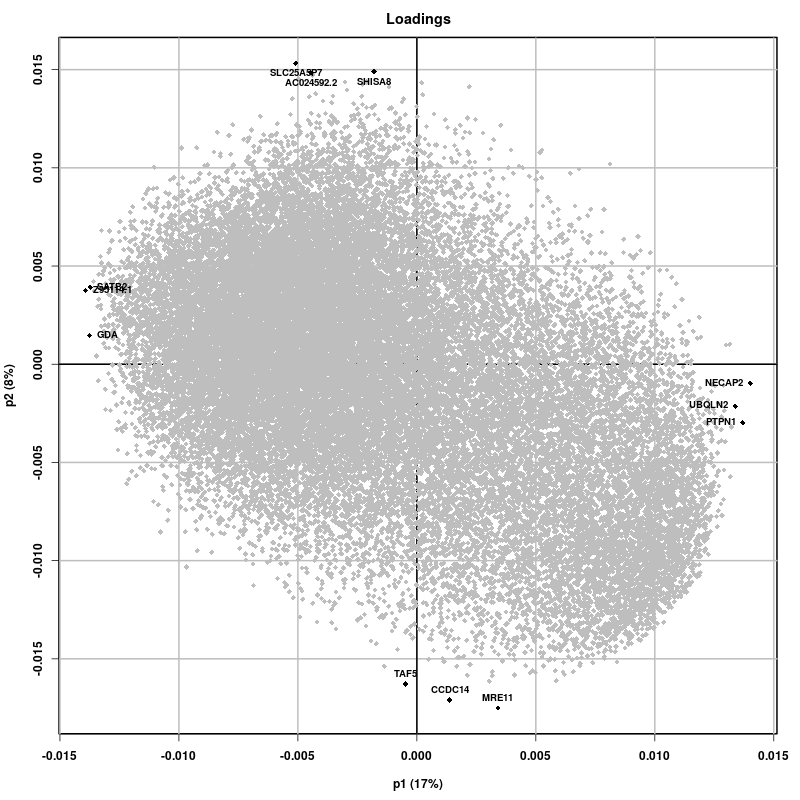

In [168]:
%R -w 800 -h 800 plot_opls(model, 'x-loading')

While the model is not very good, it highlights some interesting genes which seem to align with more rather than fewer TMD patients:

The top 3:
- PTPN1: "Protein tyrosine phosphatase B (PtpB) is one of the virulence factors secreted into the host cell by Mycobacterium tuberculosis. PtpB attenuates host immune defenses by interfering with signal transduction pathways in macrophages and, therefore, it is considered a promising target for the development of novel anti-tuberculosis drugs." (https://www.ncbi.nlm.nih.gov/pubmed/24155919)
- UBQLN2: "UBQLN1 and UBQLN2 are thought to facilitate degradation of ubiquitinated targets by the proteasome UBQLN1 and UBQLN2 are thought to facilitate degradation of ubiquitinated targets by the proteasome [19,20]. More recently, they have also been shown to play a role in autophagy. Ubiquilins associate with autophagosomes, participate in autophagosome formation, and protect against starvation-induced cell death [21,22]." ... "Here, we show that UBQLN1 recognizes Mtb, acts upstream of ubiquitination, and promotes autophagy-mediated clearance of Mtb. Therefore, we provide evidence that UBQLN1 serves as a link between the bacterial surface and the host autophagy pathway." https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4520715/, 2015
- NECAP2: related to endocytosis, no mentions in context of TB

Unfortunately this package does not do OPLS for multivariate $Y$ :(

In [169]:
%R orthogonal_model = ropls::opls(ra, as.matrix(pa), predI=2, orthoI = NA);


Error: OPLS regression only available for a single 'y' response


## C) Early concatenation PLS-DA 

I can use rs/ps (to use shared subset) or ra/pa (to use all transcripts/proteins)

Proteins are encoded by .P suffix, transcripts by .R suffix: 

In [170]:
def concat_abundances(rna, protein):
    return pd.merge(
        rna.add_suffix('.R'), protein.add_suffix('.P'),
        left_index=T, right_index=T
    )

In [171]:
full_joined_rp = concat_abundances(rna=ra, protein=pa)
full_joined_rp.head(2)

,TSPAN6.R,DPM1.R,SCYL3.R,C1orf112.R,FGR.R,...,SERPINF1.P,CTSF.P,FTCD.P,USP25.P,PLXNB2.P
001.TMD,1.687826,-1.189430,4.956709,3.532492,6.941349,...,13.396705,6.172488,0.701885,1.291204,9.712462
006.CM,0.750583,2.436818,4.564363,-1.189430,6.874971,...,12.438645,6.207233,0.428609,1.374512,9.844042


In [172]:
joined_rp = concat_abundances(rna=rs.T, protein=ps.T)
joined_rp.head(2)

,FGR.R,CFH.R,BAD.R,CASP10.R,TFPI.R,...,CCL14.P,CCL3.P,HIST1H3F.P,HIST1H3C.P,HIST1H3H.P
001.TMD,6.941349,-1.189430,3.843445,6.973657,4.671722,...,7.349039,0.356692,6.274876,6.274876,6.274876
006.CM,6.874971,4.708614,2.436818,4.255382,4.920979,...,7.358052,0.489552,5.202891,5.202891,5.202891


In [173]:
assert all(joined_rp.index == full_joined_rp.index)

In [174]:
meningitis = clinical.loc[joined_rp.index].Meningitis

In [175]:
%R -i joined_rp -i meningitis

In [176]:
%R pca = ropls::opls(joined_rp);

PCA
21 samples x 2510 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.556   5   0


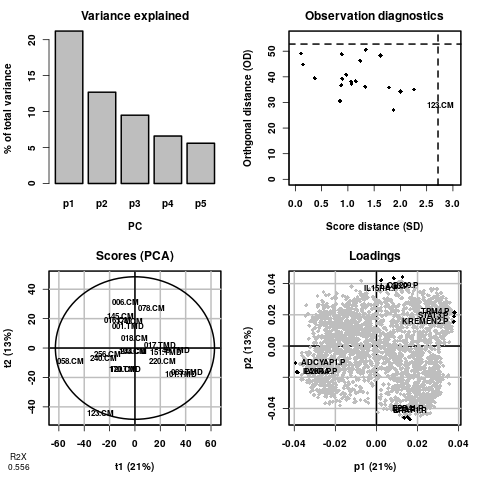

In [177]:
%R plot_summary(pca)

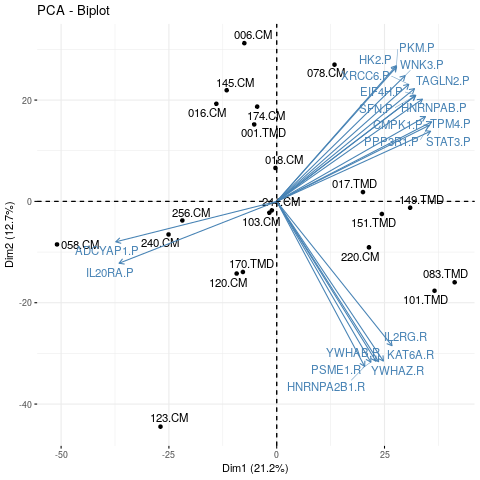

In [178]:
%%R
res.pca <- prcomp(joined_rp, scale = TRUE)
factoextra::fviz_pca_biplot(res.pca, repel = TRUE, select.var = list(cos2=20))

STAT3 sounds familiar (highlighted in 7.2)

In [179]:
%R model = ropls::opls(joined_rp, as.matrix(meningitis));

PLS-DA
21 samples x 2510 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.433    0.994   0.714 0.0425   4   0  0.1 0.05


In [180]:
%R -i full_joined_rp
%R full_model = ropls::opls(full_joined_rp, as.matrix(meningitis));

PLS-DA
21 samples x 35831 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y  pQ2
Total    0.259    0.868   0.506 0.185   2   0 0.85 0.15


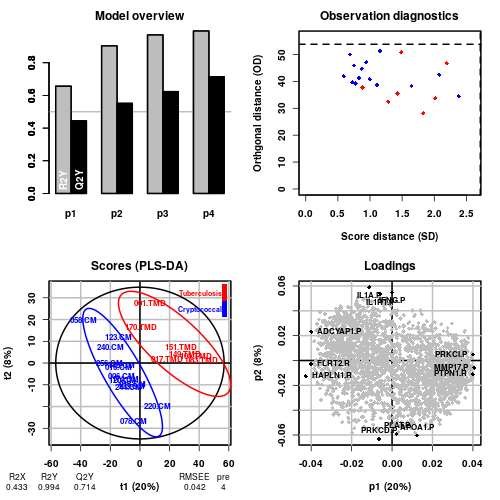

In [181]:
%%R -w 500 -h 500
plot_summary(model)

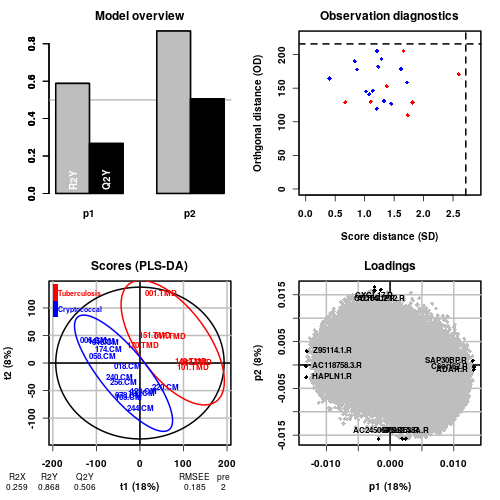

In [182]:
%%R -w 500 -h 500
plot_summary(full_model)

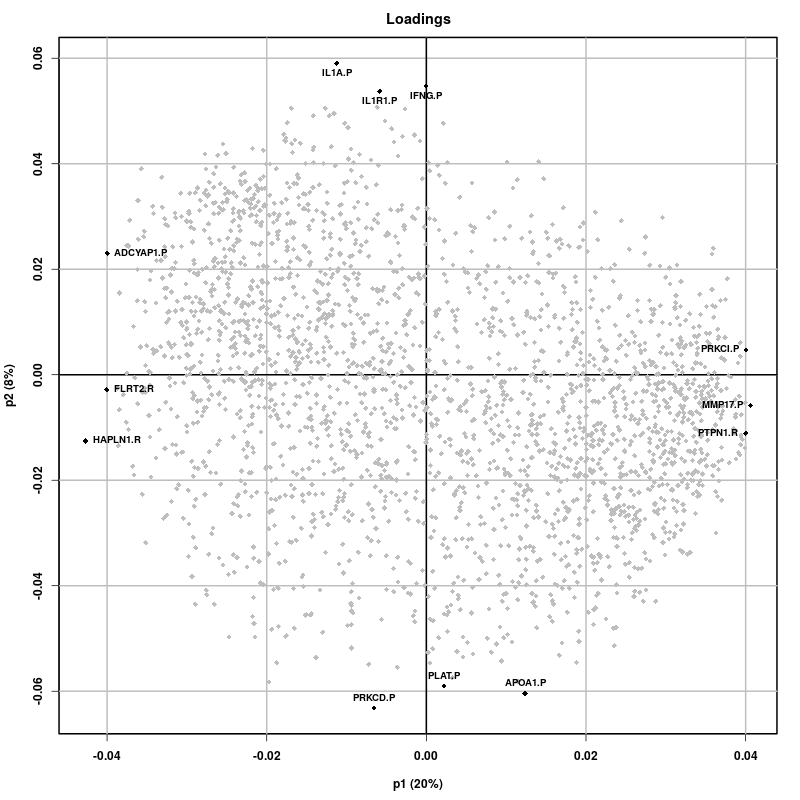

In [183]:
%%R -w 800 -h 800
plot_opls(model, "x-loading")

- HAPLN1 supposedly innocent structural protein... "we identified a BMSC-secreted factor, hyaluronan and proteoglycan link protein 1 (HAPLN1), that can induce bortezomib-resistant NF-κB activity in MM cells. Specifically, HAPLN1 proteoglycan tandem repeat (PTR) domain 1 and 2 fragments have strong PIR NF-κB–inducing activities" (http://www.jbc.org/content/293/7/2452.full)
- which is in relation with IL1 on the other side of the graph. But I am not sure of exact interpretation: why is there more IL1/R - because those are over-expressed or because they are available for detection (as in contrast with those actively bound?) - some literature on the binding process and effect on SOMAScan needed

See https://els-jbs-prod-cdn.literatumonline.com/cms/attachment/4f047efc-b13e-4fe3-a08c-2c3b274f8b25/gr1.gif

Figure from https://www.cell.com/fulltext/S0092-8674(02)01166-2

- FLRT2 (which has highly positively correlated RNA-protein levels, see point 4)
- ADCYAP1 signal transduction, NGF signaling, [TODO I have this one in my search history it means it was highlighted earlier too]

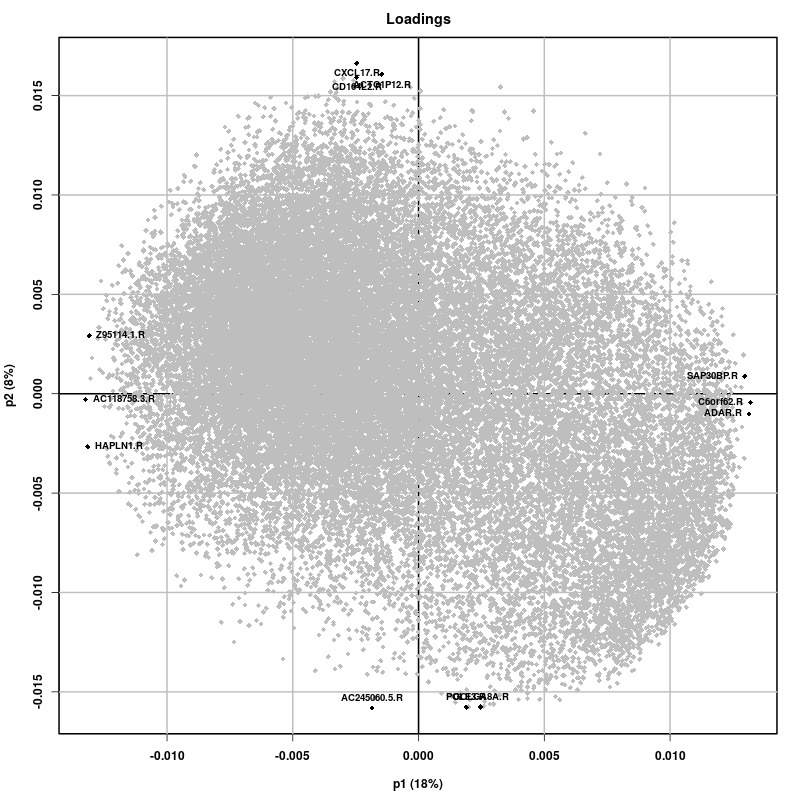

In [184]:
%%R -w 800 -h 800
plot_opls(full_model, "x-loading")

The full model performs worse which may be due to large amount of noise in the RNASeq data.
The specialized tools such as DSEq2 and limma-voom can filter or adjust for different phenomena specific to RNASeq but here it does not happen.
Possibly the best way forward would be to apply a more stringent filtering criterion (and not using everything as it is recommended for DESeq or limma and filtering later).

However what criteria would be objective for such a filtering?

Low variance - but which cutoff is right?

In [185]:
sum(full_joined_rp.var() < 1)

8054

On average fewer than one count - sounds ok (the initial filtering was considering all contrasts, it is still possible that considering other groups as well those gens could pass).

In [186]:
sum(full_joined_rp.mean() < 0)

5757

In [187]:
rp_filtered_by_mean = full_joined_rp[full_joined_rp.columns[full_joined_rp.mean() > 0]]
len(rp_filtered_by_mean.columns)

30139

In [188]:
sum(full_joined_rp.columns.str.endswith('P'))

1329

In [189]:
sum(rp_filtered_by_mean.columns.str.endswith('P'))

1280

reduction from 35k to 30k, mostly in RNASeq transcripts

In [190]:
%R -i rp_filtered_by_mean
%R mean_filtered_model = ropls::opls(rp_filtered_by_mean, as.matrix(meningitis));

PLS-DA
21 samples x 30081 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y pQ2
Total    0.282    0.841   0.482 0.203   2   0  0.6 0.1


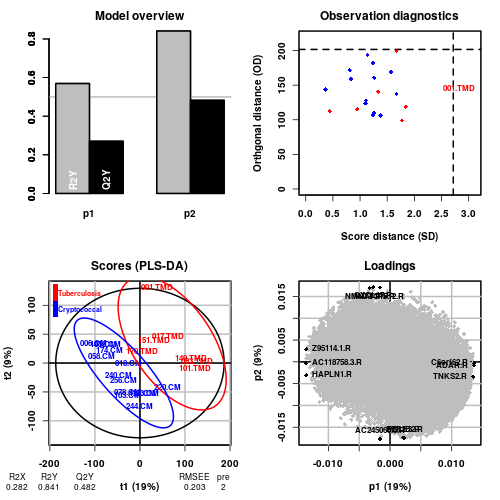

In [191]:
%%R -w 500 -h 500
plot_summary(mean_filtered_model)

not much better...

TODO: 001.TMD looks like an outlier (and always looked like one) - reject it?

#### With validation

In [192]:
%%R
# TODO: sacrificing half of the data is a bit too much... is there a way to enforce other split with this package?
val_model = ropls::opls(joined_rp, as.matrix(meningitis), subset='odd', crossvalI=7);

PLS-DA
11 samples x 2510 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE RMSEP pre ort
Total    0.283    0.955   0.496 0.119 0.266   2   0


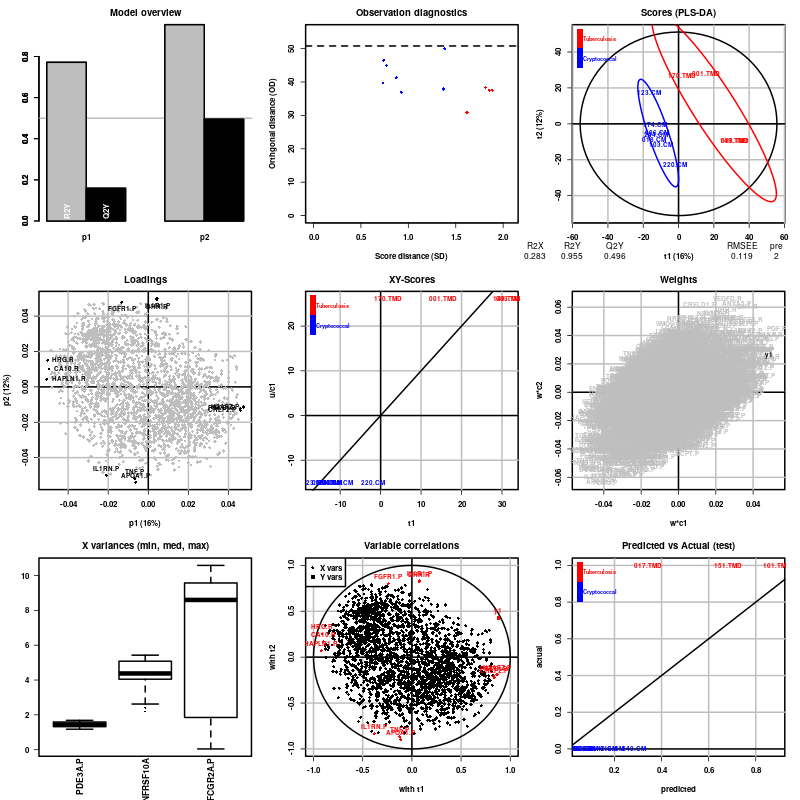

In [193]:
%%R -w 800 -h 800
plot_opls_all(val_model, test=T)

TODO: Predicted vs Actual is not very useful, ROC would be much better.

In [194]:
#library(plotROC)
#basicplot <- ggplot(test, aes(d = D, m = M1)) + geom_roc()

TODO: use remaining TB patients for validation?

The model train on reduced number of patients still recovers similar proteins:

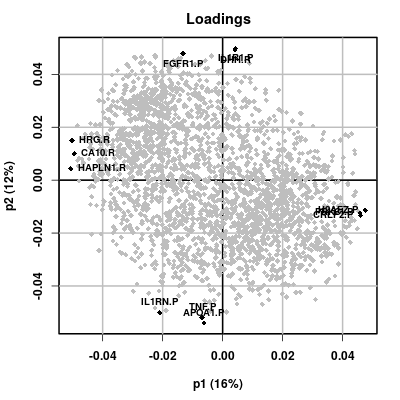

In [195]:
%%R -w 400 -h 400
plot_opls(val_model, "x-loading")

But is it better than doing things separately?

TOOD: pathway analysis